# Investigation of Methane Activation over NiO/CZ using in-situ FTIR Spectroscopy

# Introduction

Vibration of molecules, specially organics, adsorbs energy at infra-red (IR) levels, which makes FTIR spectroscopy a powerful tool for detection and identification of different molecules. The characteristic peaks detected by FTIR spectroscopy depend on the chemical bond and the vibrational mode. Provided with a large enough library of spectra of chemicals, FTIR spectroscopy alone should be sufficient for identification and quantification the composition of the sample tested through linear combination fitting. However, in the field of surface chemistry, due the volatility and the overlapping nature of characteristics peaks of surface species (as they are highly dependent on the surface of adsorption and could form complex features in the IR band), it is already not as trivial for the identification of surface species without a thorough understanding of the adsoprtion surface and the surface species; let alone the quantification of different surface species. To address the challenge, our team: [Yimeng Lyu and Dr. Carsten Sievers Group from Georgia Tech](https://sievers.chbe.gatech.edu/), developed the following novel algorithm in the aim of the identifying and deconvoluting the contribution of different surface species over time in a series of time resolved IR spectra from methane activation over NiO/CZ catalysts. 


## The Algorithm

Here, we present a series of time-resolved IR spectra from methane activaiton over the 2wt% NiO/CZ catalyst. The goal is to develop a new algorithm that is capable of routinely 1) identifying all the surface species and 2) quantifying the evolution of different surface species over time. 


### Identification of Surface Species
As mentioned previously, each surface species produces one or more unique characteristic peaks in the IR spectrum. Hence, the first logical step for identification of all surface species is to find all the peaks among all spectra at different times. [Keles et. al.](https://pubs.rsc.org/en/Content/ArticleLanding/AN/2014/C3AN01879B#!divAbstract) demonstrated non-linear curve fitting routines to fit series of IR spectra, where they used local maxima in the 1st  IR spectrum of each time series as indicators for existing peaks. While the approach is mathematically sound, it often fails to capture small peaks that are adjacent to larger peaks. Additionally, it works poorly when the signal-to-noise ratio of the spectra are non-ideal. 

To address these disadvantages, we propose to analyze the difference between spectra at adjacent times, i.e. the 'derivative of the series of data with time', using non-linear regression fitting. The analysis of the difference between spectra better reveals peaks that arises at later times, specially if they were shadowed by the largers that rises earlier. Non-linear regression fitting optimizes the difference between the model and the data set, which handles data sets with low signal-to-noise ratio.

Even though we know already that some of the peaks are correlated as they may belong to the same surface species, because the goal here is to find all the possible peaks, such limitations are ignored temperarily. In this step, a vector basis that contains all possible peaks is established and optimized. The variables fitted include the peak positions ($\mu$), peak variances ($\sigma$) and peak amplitudes (a) of each peak in the vector basis. The number of peaks and peak type of each peak are fixed, or the required input variables. As the analysis applies to a series of time-resolved data set, it is reasonable to assume that the peak shape, defined by the peak position ($\mu$) and peak variance ($\sigma$) should be constant over time, or at least over a certain period of time, as changes in the peak position or variance is an indication of changes in the chemical properties of the surface species. 

Finally, the loss function optimized using non-linear regression fitting is: 

$Loss_{IG}(\vec{a},\vec{\mu},\vec{\sigma}) = \sum_i \bigg(y_i - \sum_j a_{ij} F(\mu_{j},\sigma_{j}) \bigg)$

, where $\vec{y}$ is the vector that contains spectra at different times, 

$\vec{a}$ are the peak amplitudes for each peak at different times, 

$\vec{\mu}$ are the peak positions, 

and $\vec{\sigma}$ are the peak variances; 

the index i refers to the number of spectra at different times, 

and the index j refers to the number of peaks in the vector basis. 

The peak positions and variances are fixed over time. Only the amplitudes are changing with time, and they represent the relative quantity of different species at different times. The $F$ refers to the peak type, which could be either a Gaussian or a Voigt peak. 


### Construction of Vector Basis for All Surface Species

Now that all the possible peaks over all times have been identified, the next step is to find the chemical assignment to each peak. Basically, peaks that arises from different vibrational modes of the same species should be grouped together, as their relative ampltitude should be consistent at different times. Such assignment can be assisted by 1) examining the correlation matrix, 2) looking up peak assignments in the literature, and 3) referring to the reference experiments carried out by dosing probe molecules over the same surface. 


### Evolution of Surface Species by Non-Linear Regression Fitting 

The previous two steps established some basic understanding on the surface species and their charateristic peaks, i.e. how many surface species are their and how many peaks each species has. The final step is to reveal the evolution of surface species over time. Again, we start from the mathematical description of the problem. 

Assuming there are $n$ surface species, each consists of one or more peaks, representing different vibrational modes in the region of interest. To describe such a surface species mathematically, we have: 

$S_j = \sum_k\alpha_{jk} F(\mu_j,\sigma_j)$

, where j is the index of different surface species, 

and k is the index of peaks from each species. 

$\alpha_{jk}$ is the amplitute of each independent peak, 

and $F$ is the peak type which is either a Gaussian, or Voigt peak; 

and the shape of peak is defined by the peak position $\mu$, and peak variance $\sigma$. 

The key difference from the establishment in step 1 is that the ratios between the amplitudes of each peaks in the vector space is now fixed over time. This is basically the mathematical expression defining these peaks are from the same species. 

We can construct a 'vector basis', where all possible species are included. 

$X = \{S_0, S_1, S_2, ...\}$

If we knew the hyperparameters that define vectors for each species, the model becomes linear, i.e.:

$\vec{y} = \vec{\omega}\vec{X} + b$

, where $\vec{\omega}$ is the amplitude of each species, which again is a representation of the relative quantity of the species at different times. 

However, we want to optimize $\vec{\omega}$ together with the hyperparameters, which turns the problem non-linear. Hence, we define the loss function to optimize as: 

$Loss((\alpha, \mu, \sigma), \omega) = \sum_i (\vec{y_i} - \vec{y_{model,i}})^2$

, where $\vec{y_{model}}$ is defined as: 

$y_{model,i} = \sum_j\omega_{ij}\sum_k\alpha_{jk} F(\mu_j,\sigma_j)$

## Import Packages and Pre-Defined Functions

In [1]:
import matplotlib.pyplot as plt
from scipy import special
import numpy as np
from lmfit import minimize, Parameters, report_fit, Minimizer
from lmfit.models import GaussianModel, VoigtModel
import seaborn as sns
import time
import pandas as pd
from ipynb.fs.full.functions import get_first_nbr_from_str, baseline_als

In [2]:
from ipynb.fs.full.functions import Voigt, Gaussian
from ipynb.fs.full.functions import Generate_data, Generate_params, loss_func, Plot_data, Plot_com_data, Print_var
from ipynb.fs.full.functions import Generate_Vec_IG, Generate_data_IG, loss_func_IG, Generate_params_IG, Plot_data_IG


# Test on the real data set

## Import data
Import data from '20200914_cleaned.xlsx'. Import the difference data and accumulation data.

180.0
360.0
The fitted region started at 2819.463 cm-1, and ended at 2971.814 cm-1.


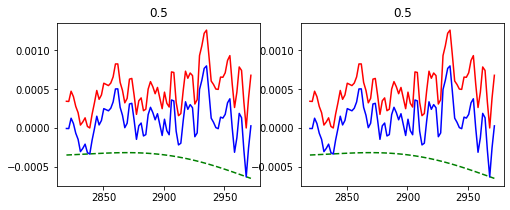

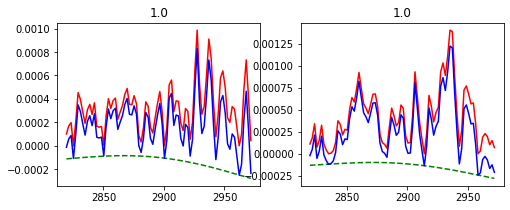

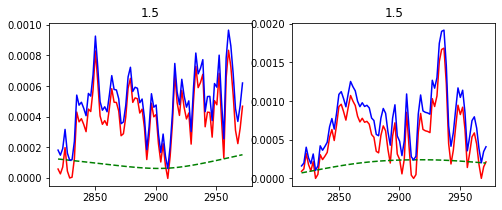

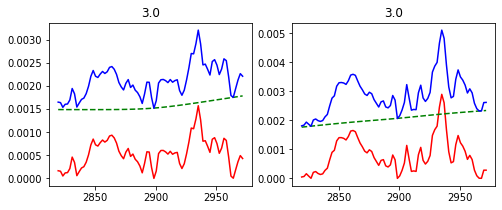

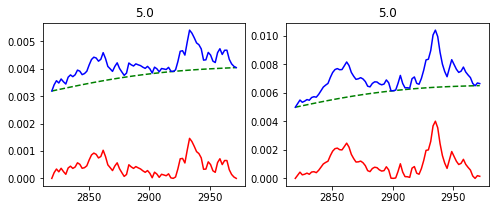

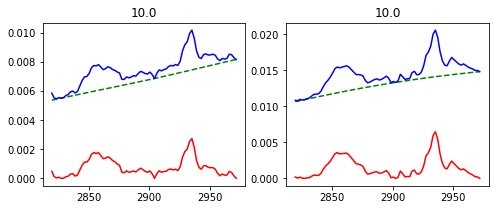

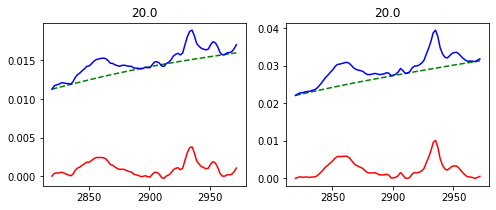

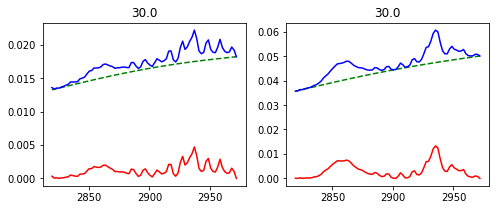

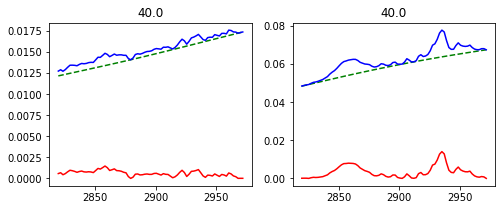

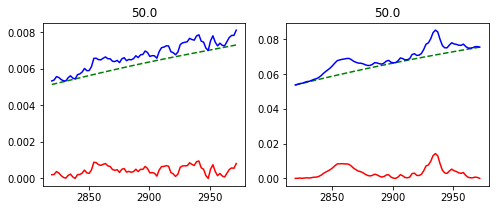

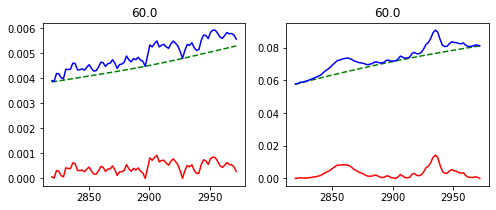

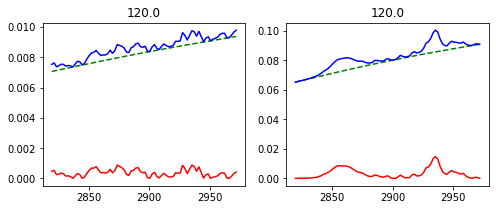

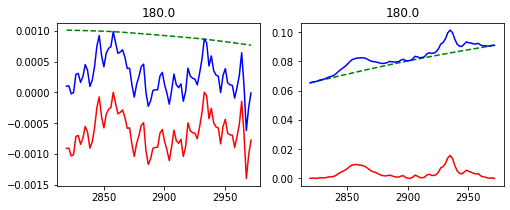

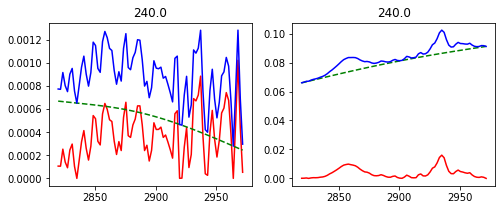

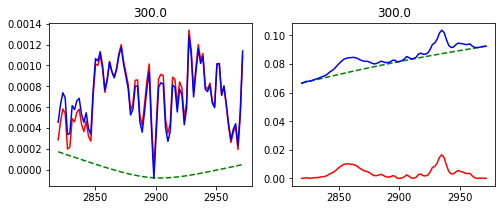

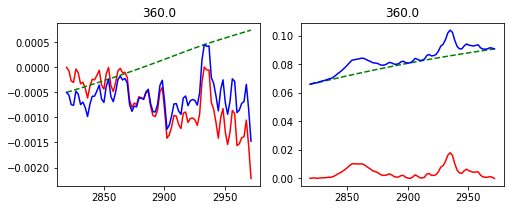

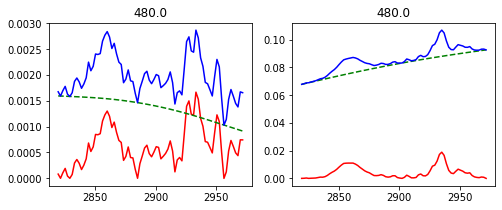

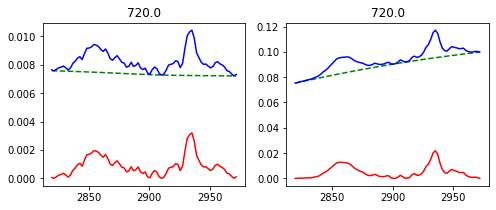

In [3]:
df = pd.read_excel (r'20200918.xlsx')
column_num = len(df.columns)

sns.color_palette(n_colors = column_num)
ratio = 1
INR = 1       #index of reference spectrum

###accumulation and differences
dif = pd.DataFrame(df,columns = [df.columns[0]])
acu = pd.DataFrame(df,columns = [df.columns[0]])



sns.set_palette("husl",column_num)
for i in range(INR+1,column_num):
    if i == INR+1:
        dif[df.columns[i]] = df[df.columns[i]] - df[df.columns[INR]]*ratio
        acu[df.columns[i]] = dif[df.columns[i]]
    else:
        dif[df.columns[i]] = df[df.columns[i]] - df[df.columns[i-1]]
        acu[df.columns[i]] = acu[df.columns[i-1]] + dif[df.columns[i]]     


column_num_new = np.shape(dif)[1]
SCH = 1255     #start index of CH 
ECH = 1335     #end index of CH
a = np.transpose(acu[[dif.columns[0]]][SCH:ECH].to_numpy())
WN = a[0]
CH_acu = []
CH_dif = []
time_CH = np.zeros(column_num-1)

for i in range(1,column_num-1):
    time_CH[i-1] = get_first_nbr_from_str(df.columns[i+1])
    a = np.transpose(dif[[dif.columns[i]]][SCH:ECH].to_numpy())
    a = a[0]
    ##baseline correction
    if a[38] < a[0]:
        print(get_first_nbr_from_str(dif.columns[i]))
        b = -a
        bsl = baseline_als(b, 105, 0.0001)
        y = -(b - bsl)
        bsl = -bsl
    else:
        bsl = baseline_als(a, 105, 0.0001)
        y = a - bsl

    
    a_acu = np.transpose(acu[[dif.columns[i]]][SCH:ECH].to_numpy())[0]
    bsl_acu = baseline_als(a_acu, 105, 0.0001)
    y_acu = a_acu-bsl_acu
    CH_dif.append(y)
    CH_acu.append(y_acu)
    fig,ax = plt.subplots(1,2,figsize=(8,3))
    ax[0].plot(WN,y,'r')
    ax[0].plot(WN,bsl,'g--')
    ax[0].plot(WN,a,'b')
    ax[0].set_title(time_CH[i-1])
    ax[1].plot(WN,y_acu,'r')
    ax[1].plot(WN,bsl_acu,'g--')
    ax[1].plot(WN,a_acu,'b')
    ax[1].set_title(time_CH[i-1]) 
print('The fitted region started at {0} cm-1, and ended at {1} cm-1.'.format(WN[0], WN[-1]))
x_CC = np.array(WN)
y_CC = np.array(CH_acu)

In [120]:
column_num_new = np.shape(dif)[1]
S = 455
E = 675
b = np.transpose(dif[[dif.columns[0]]][S:E].to_numpy())
WN = b[0]
CC = []
CC_acu = []
Time = []
for i in range(1,column_num_new):
    a = np.transpose(dif[[dif.columns[i]]][S:E].to_numpy())
    b = np.transpose(acu[[dif.columns[i]]][S:E].to_numpy())
    CC.append(a[0])
    CC_acu.append(b[0])
    Time.append(get_first_nbr_from_str(dif.columns[i]))
x_CC = np.array(WN)
y_CC = np.array(CC)
Time = np.array(Time)
print('The fitted region started at {0} cm-1, and ended at {1} cm-1.'.format(WN[0], WN[-1]))

The fitted region started at 1276.665 cm-1, and ended at 1718.291 cm-1.


In [149]:
print(len(x_CO))
Min_ind = np.argmin(y_CO[-2])
print(Min_ind)
print(y_CO[-1][Min_ind])
print(x_CO[Min_ind])

115
57
-0.0012564151271375543
1145.527


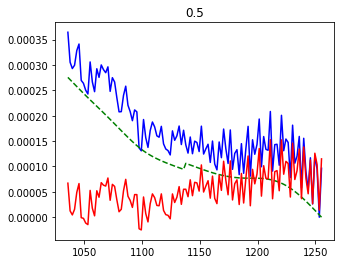

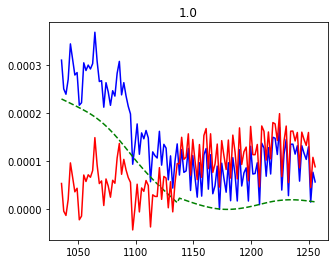

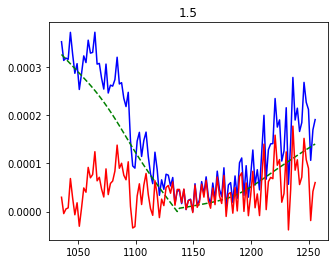

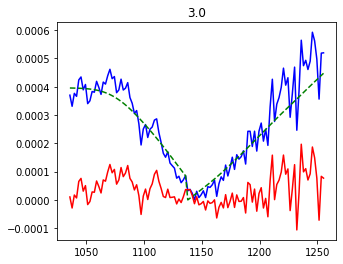

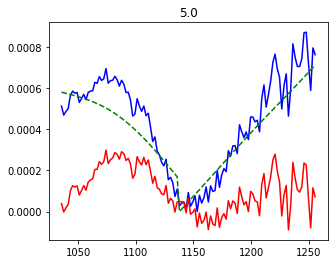

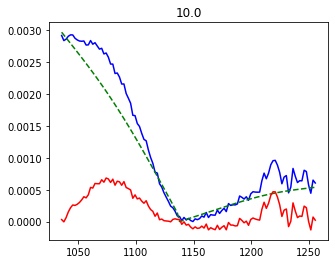

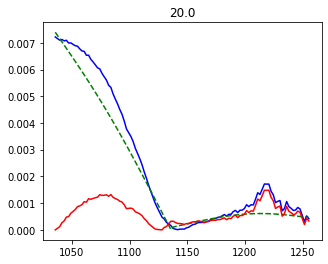

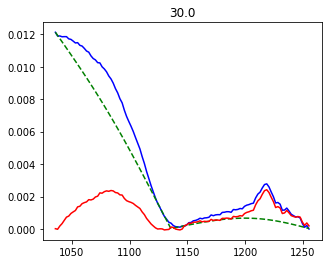

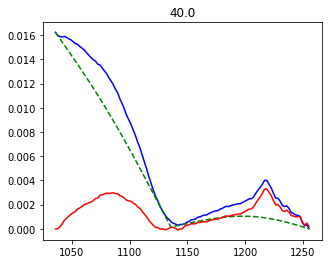

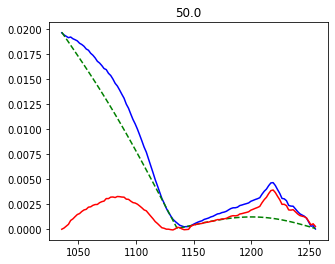

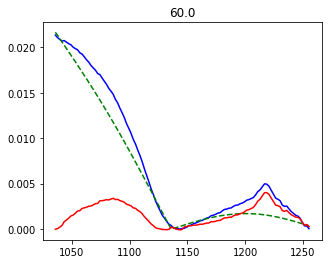

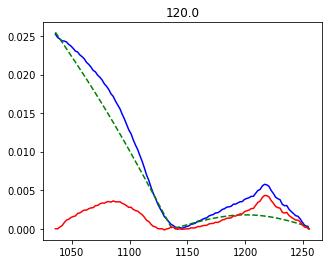

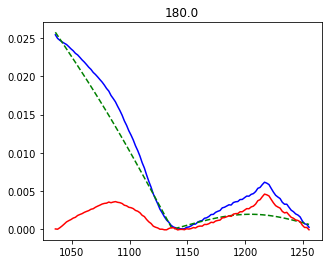

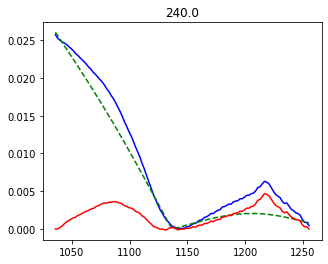

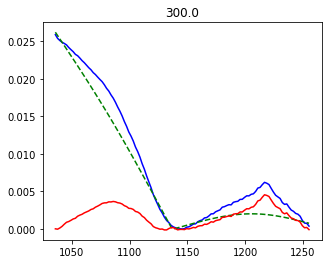

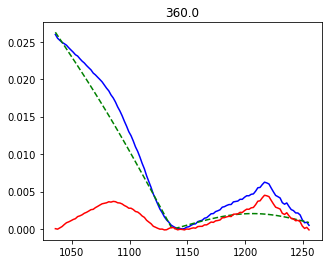

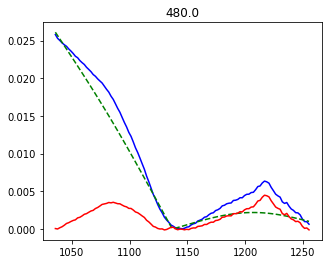

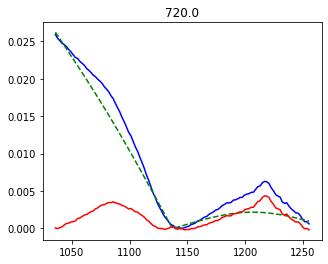

In [228]:
column_num_new = np.shape(dif)[1]
SCO = 330
ECO = 445
LCO = ECO-SCO
b = np.transpose(dif[[dif.columns[0]]][SCO:ECO].to_numpy())
WN = b[0]
CO = []
Min_ind = 53
for i in range(1,column_num_new):
    a = np.transpose(acu[[dif.columns[i]]][SCO:ECO].to_numpy())
    a1 = a[0][:Min_ind]
    a2 = a[0][Min_ind:]
    if i < 5:
        bsl1 = baseline_als(a1, 1005, 0.05)
        bsl2 = baseline_als(a2, 1005, 0.05)
    else: 
        bsl1 = baseline_als(a1, 105, 0.0005)
        bsl2 = baseline_als(a2, 105, 0.0005)
    y1 = a1 - bsl1
    y2 = a2 - bsl2
    DIF = y1[-1] - y2[0]
    y2 = y2 + DIF
    y = np.concatenate((y1,y2))
    bsl = np.concatenate((bsl1,bsl2))
    if i >= 8:
        bsl3 = baseline_als( y[48:58],5,0.5)
        y[48:58] = y[48:58] - bsl3
    CO.append(y)
    fig = plt.figure(figsize=(5,4))
    plt.plot(WN,a[0]-a[0].min(),'b-')
    plt.plot(WN,bsl-bsl.min(),'g--')
    plt.plot(WN,CO[-1],'r-')
    plt.title(time_CH[i-1])

x_CO = np.array(WN)
y_CO = np.array(CO)

## Finding a good initial guess

By implementing the lmfit package, we can performance the optimzation of our loss function by minimizing the least square of the difference between the model and actual data. The 'leastsq' method from the lmfit package uses the 'Levenberg-Marquardt' algorithm for the minization. While often criticized, including the fact it finds
a local minima, this approach has some distinct advantages. These include being fast, and well-behaved for most
curve-fitting needs, and making it easy to estimate uncertainties for and correlations between pairs of fit variables. Still the disadvantage of the 'Levenberg-Marquardt' algorithm which is its looking for local minima should be addressed. Hence, the first step in our modeling methodology is finding a reasonable initial guess so that further optimization would have better performances. 

## Fitting the C-H vibrations

In [81]:
Vec_IG = {'Mus':np.array([2861.9,2952,2853.1,2934.2]),
          'Sigmas':np.array([6.7,3.6,4.1,2.9]),
          'Types':np.array([1,1,1,1]),
          'Fixed':None,
          'Lims':None}

In [82]:
t0 = time.time()
fit_params_IG = Generate_params_IG(x,Vec_IG,ndata =18)

fitter = Minimizer(loss_func_IG, fit_params_IG, fcn_args=(x, y, Vec_IG))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 46.986324071884155


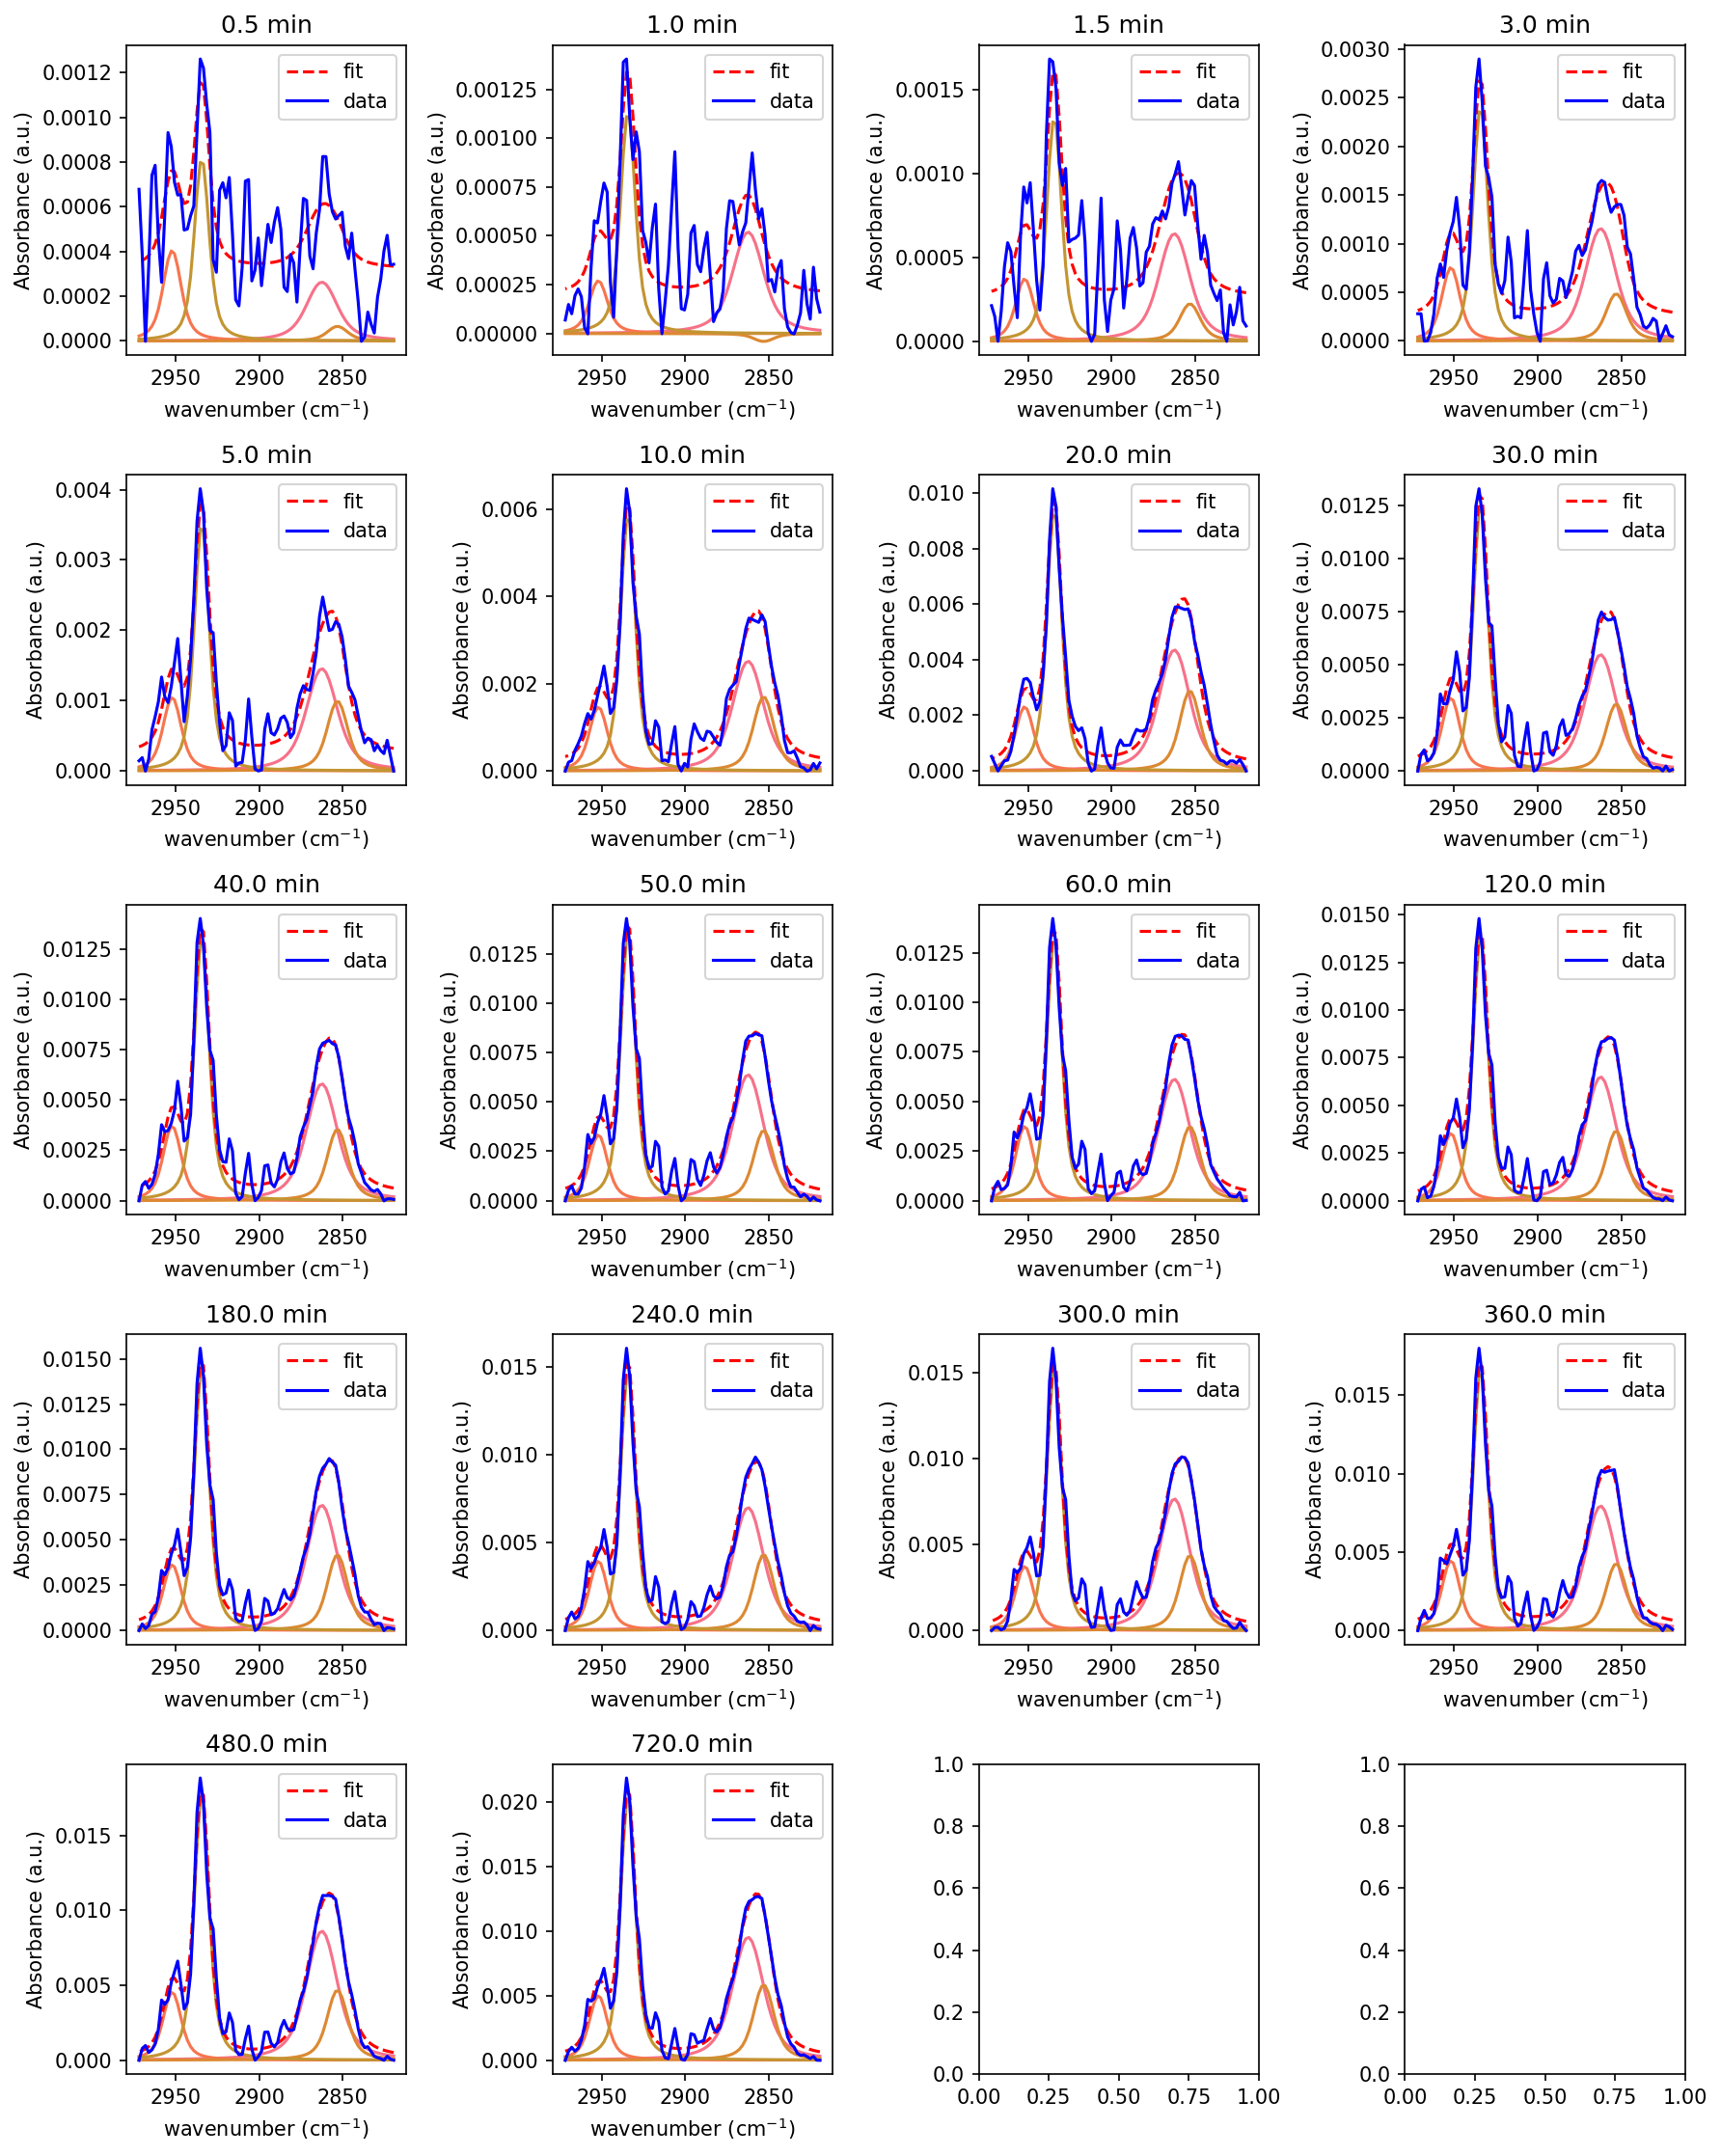

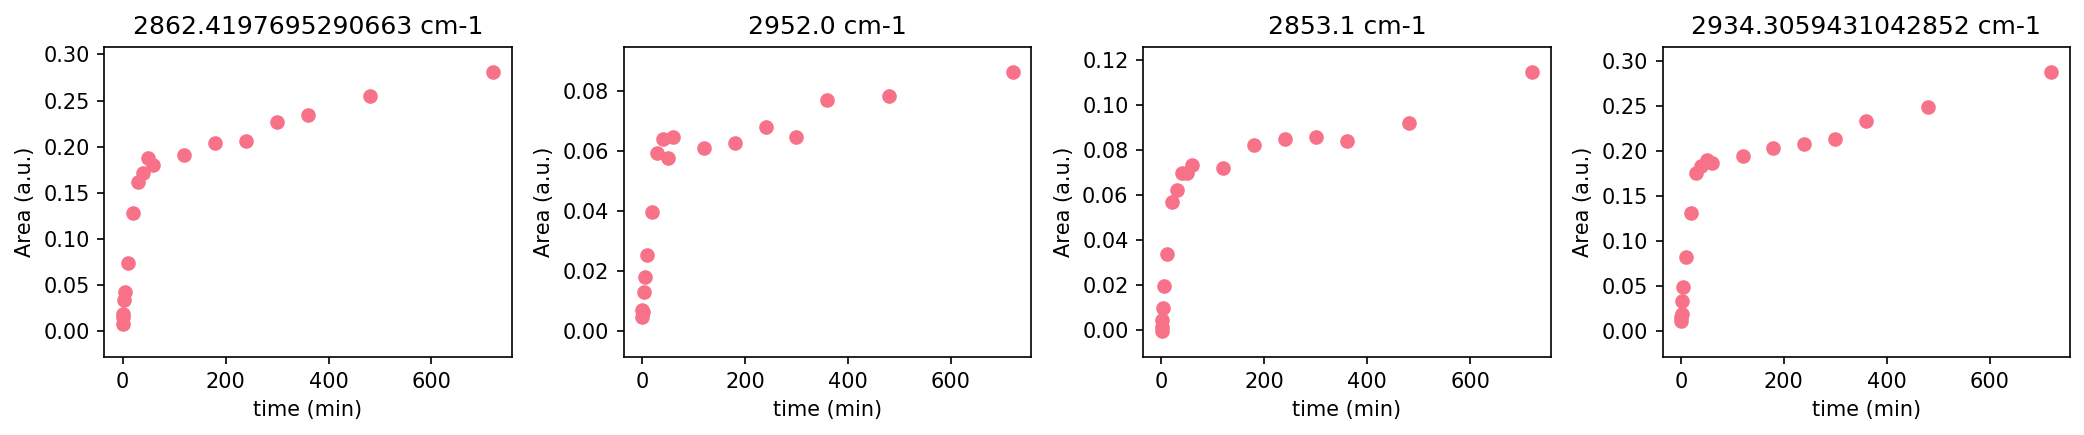

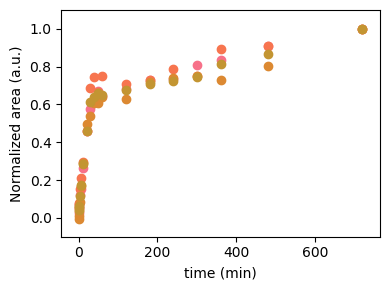

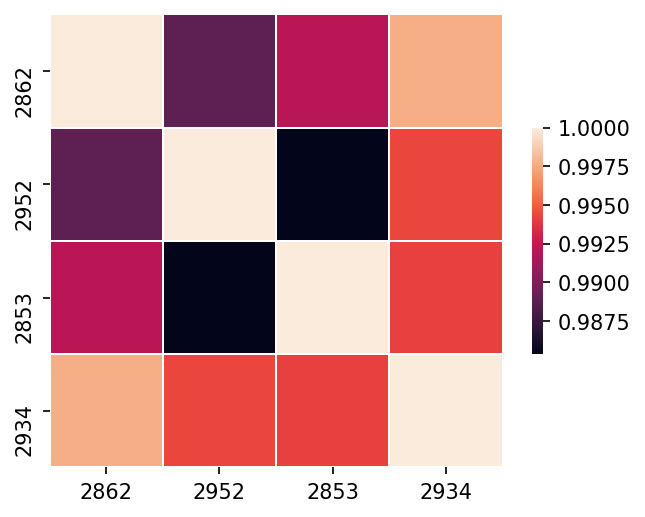

{'Peak Pos': [2862, 2952, 2853, 2934],
 'Amps': array([[ 0.00775737,  0.00697775,  0.0012756 ,  0.01141289],
        [ 0.015328  ,  0.00466578, -0.00078923,  0.01586059],
        [ 0.01892948,  0.00640824,  0.00437196,  0.01870168],
        [ 0.0340589 ,  0.01303097,  0.00953354,  0.03364407],
        [ 0.04287599,  0.01805352,  0.01949773,  0.04919296],
        [ 0.07422565,  0.02529625,  0.03341299,  0.08245115],
        [ 0.1284174 ,  0.03980298,  0.05654158,  0.1314366 ],
        [ 0.16140447,  0.05930027,  0.0618486 ,  0.17534281],
        [ 0.17135664,  0.06401982,  0.06956907,  0.18353114],
        [ 0.18802035,  0.05756606,  0.06976977,  0.19017727],
        [ 0.18050641,  0.064718  ,  0.07316367,  0.18609105],
        [ 0.19143853,  0.06105221,  0.07180186,  0.19408563],
        [ 0.20406152,  0.06276451,  0.08193843,  0.20332547],
        [ 0.20596364,  0.06797315,  0.08455163,  0.20721736],
        [ 0.22632204,  0.0645928 ,  0.0857307 ,  0.21353057],
        [ 0.2343774 ,  

In [83]:
params_IG = result.params
Plot_data_IG(params_IG,x,y,Vec_IG,time_CH[:18],False)

In [84]:
Vec_IG_struc = {'Peaks':[[0,1,2,3]],'Types':[[1,1,1,1]]}
Vec_fit = Generate_Vec_IG(params_IG,Vec_IG_struc,18)
Vec_fit['Vec0']['Lims'] = {'Peaks':np.array([0,1,2,3]),
                           'Specs':np.array([[0.1,0.1,0.1,0.1],
                                            [4000,4000,4000,4000],
                                            [0.1,.1,0.1,0.1],
                                            [6.5,6.5,6.5,6.5]])}

In [85]:
t0 = time.time()
fit_params = Generate_params(x,Vec_fit,ndata = 18)

fitter = Minimizer(loss_func, fit_params, fcn_args=(x, y, Vec_fit))
result = fitter.minimize(method='leastsq')
t1 = time.time()

print('The time cost is:',t1-t0)

0 6.158791152365902 0.1 6.5
0 2862.4197695290663 2842.4197695290663 2882.4197695290663
0 3.6 0.1 6.5
0 2952.0 2932.0 2972.0
0 4.1 0.1 6.5
0 2853.1 2833.1 2873.1
0 2.9188491530152327 0.1 6.5
0 2934.3059431042852 2914.3059431042852 2954.3059431042852
The time cost is: 29.02945613861084


In [86]:
new_params = result.params
report_fit(new_params)

[[Variables]]
    lin_0:     3.3034e-04 +/- 9.1725e-05 (27.77%) (init = 0)
    amp_000:   0.00997648 +/- 0.00444257 (44.53%) (init = 0.003991685)
    cen_000:   2862.18084 +/- 1.53248535 (0.05%) (init = 2862.42)
    sig_000:   6.04901926 +/- 0.42939078 (7.10%) (init = 6.158791)
    amp_001:   0.00289750 +/- 0.00114275 (39.44%) (init = 0.001306746)
    cen_001:   2951.93841 +/- 0.16216981 (0.01%) (init = 2952)
    sig_001:   3.19970366 +/- 0.13554001 (4.24%) (init = 3.6)
    amp_002:   0.00339278 +/- 0.00225857 (66.57%) (init = 0.001541984)
    cen_002:   2852.70223 +/- 0.76918241 (0.03%) (init = 2853.1)
    sig_002:   3.88746853 +/- 0.58921186 (15.16%) (init = 4.1)
    amp_003:   0.00989774 +/- 0.00388580 (39.26%) (init = 0.004059495)
    cen_003:   2934.33410 +/- 0.04140465 (0.00%) (init = 2934.306)
    sig_003:   2.93106940 +/- 0.03409257 (1.16%) (init = 2.918849)
    lin_1:     1.9194e-04 +/- 9.1749e-05 (47.80%) (init = 0)
    amp_100:   0.01393095 +/- 0.00488934 (35.10%) (init = 0.

Plotting.....


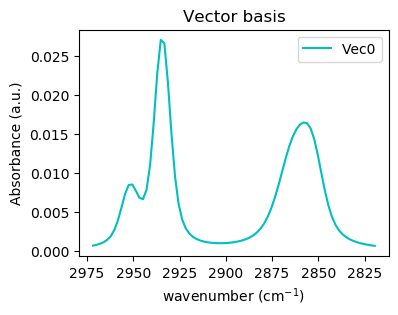

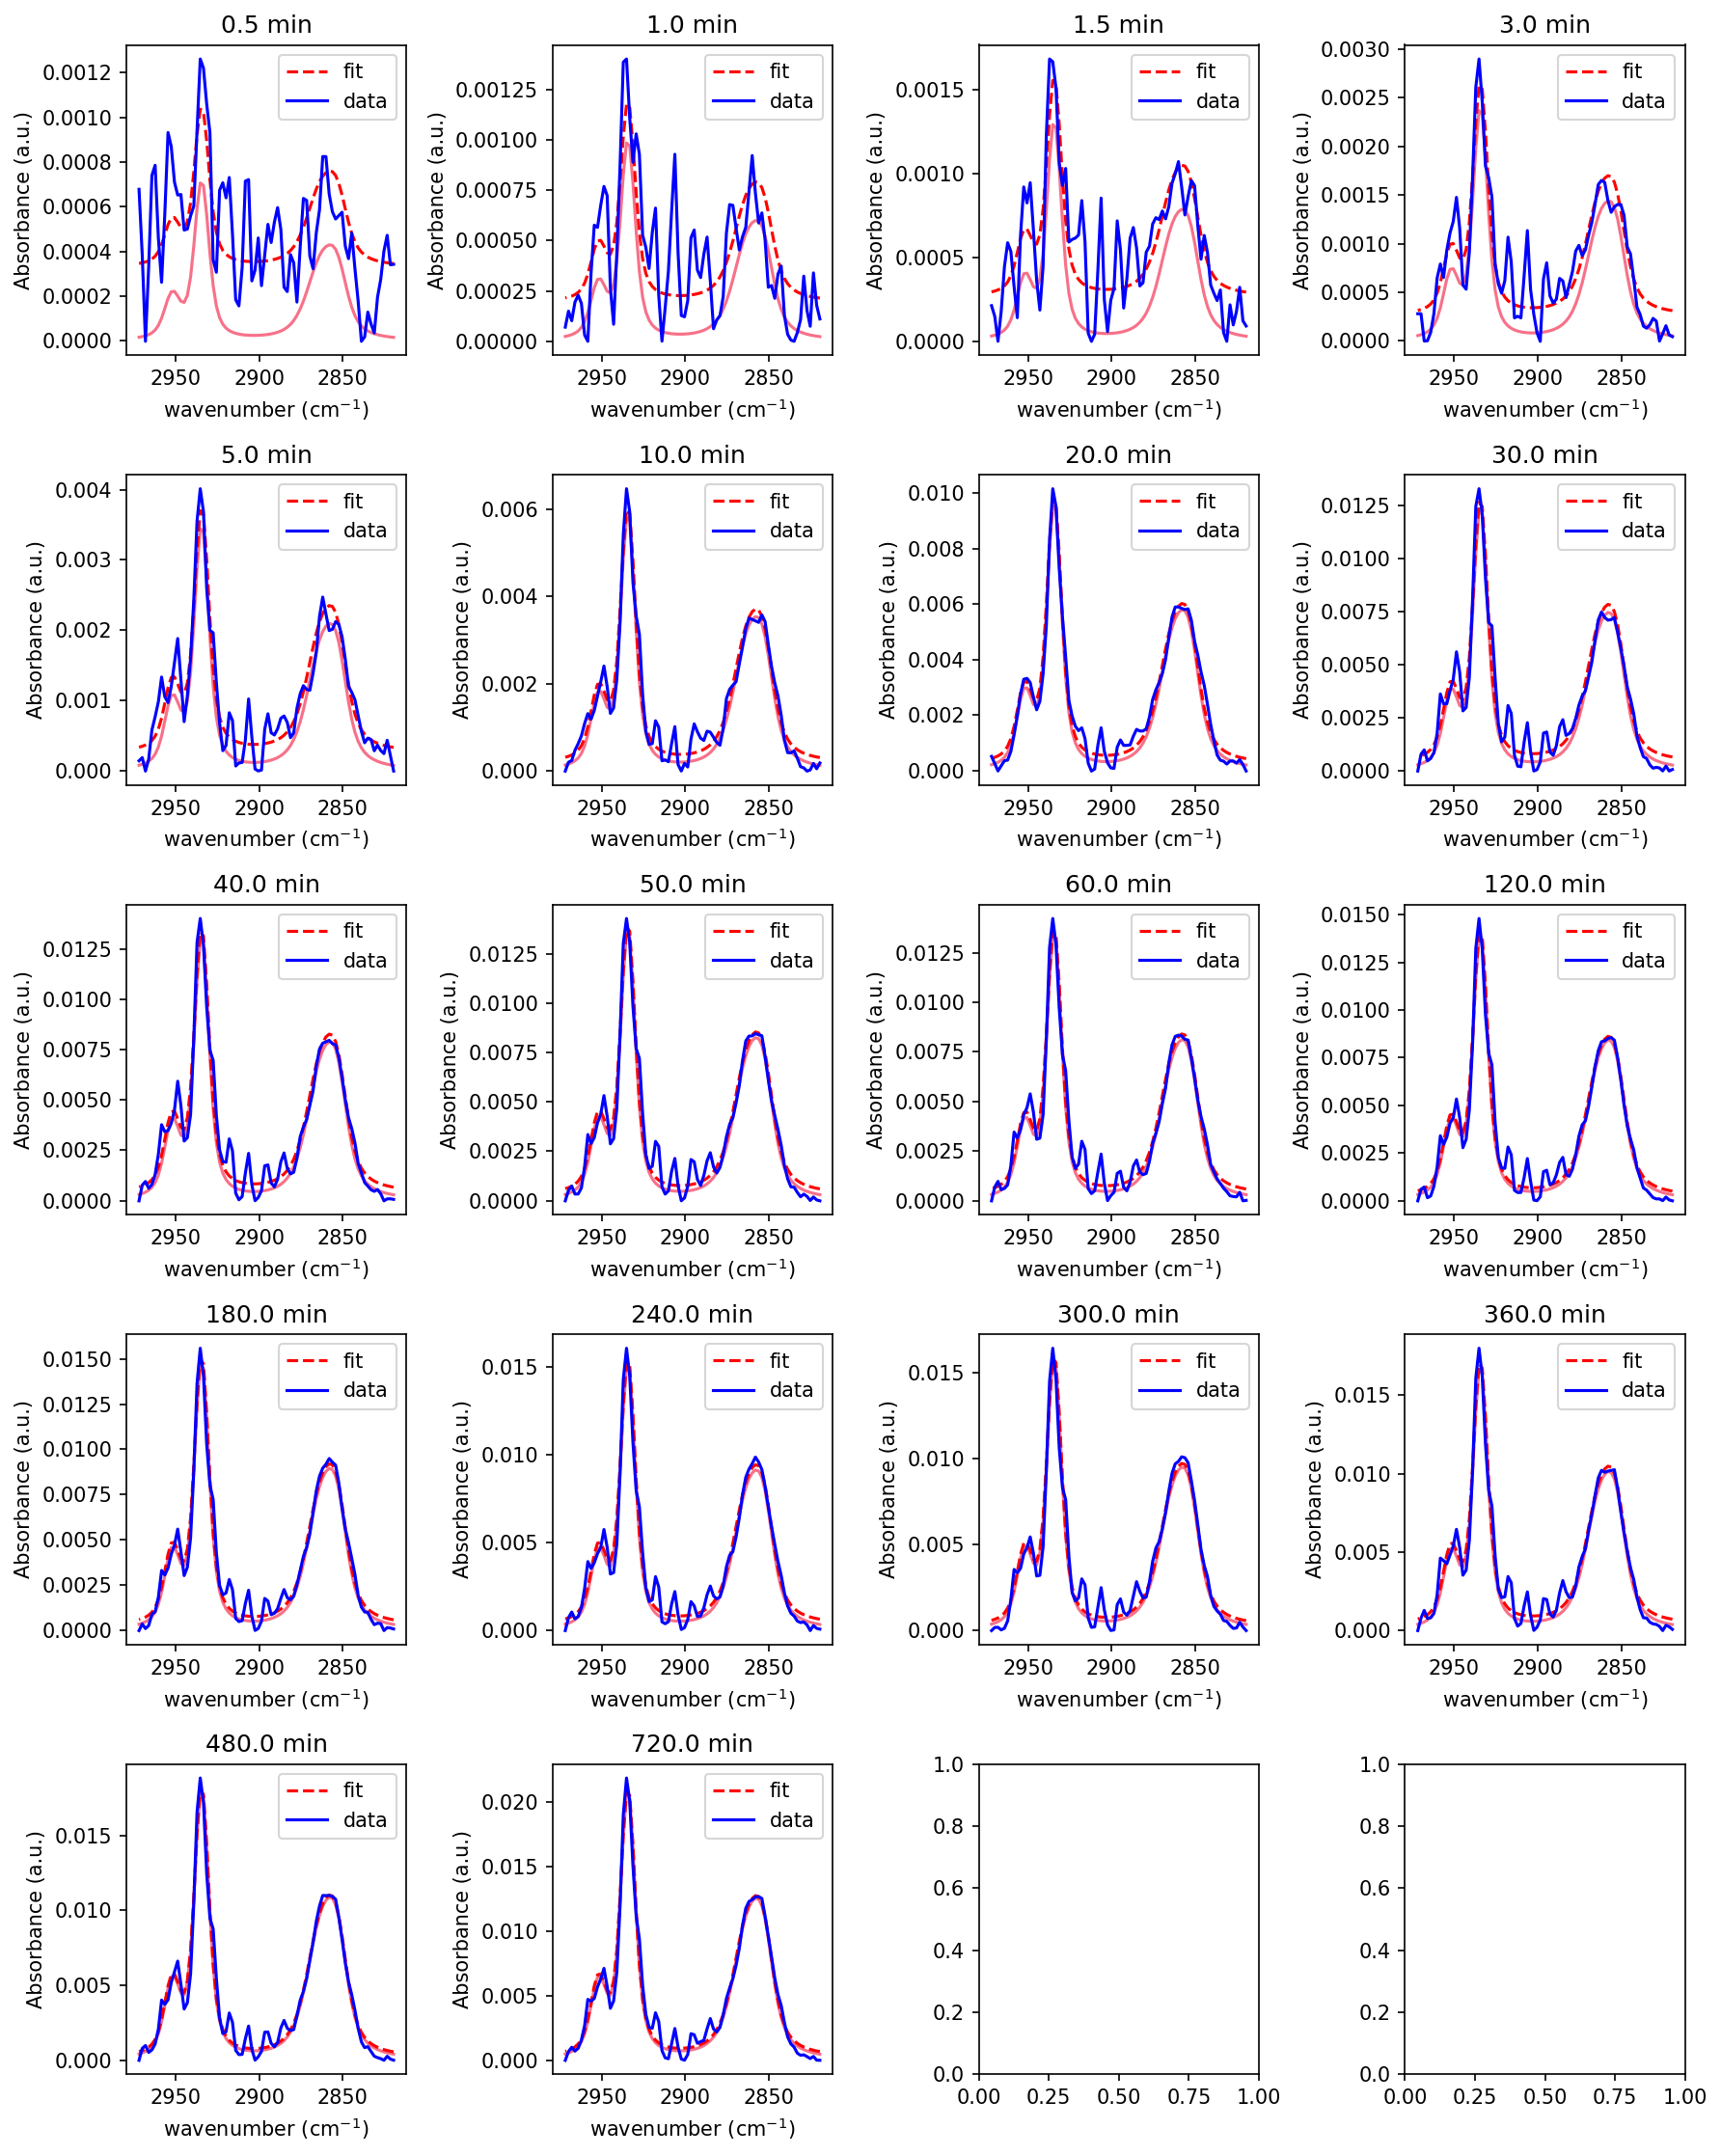

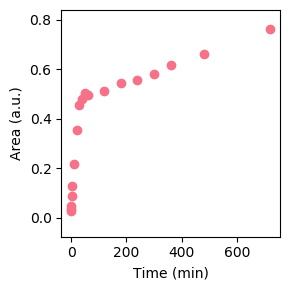

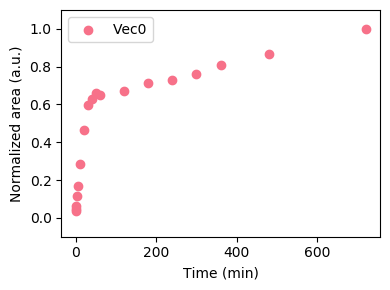

In [87]:
Plot_data(new_params,x,y,Vec_fit,time_CH[:18],False)

## Fitting the 1300-1700 cm$^{-1}$ region

We want to include a peak around 1600 cm$^{-1}$ as the C=O species, two peaks around 1540 cm$^{-1}$ for carbonates, 4 peaks around 1300 cm$^{-1}$ to 1500 cm$^{-1}$ for aromatics and finally, a two peaks around 1350 cm$^{-1}$ for the formates.

We wanna repeat the previous procedure, i.e.:

    1) Make an initial guess on all the peaks
    2) Group the peaks and creat a vector space
    3) Use the new vector basis to perform non-linear regression fit for optimization of the parameters
   


### Fitting the initial stage (0,10) min

We use postfix _CC0 for fitting of this period.

Below is an intial guess of the peaks.

In [12]:
Vec_IG_CC0 = {'Mus':np.array([1600, 1537.8, 1541.9, 1484.9, 1405.9, 1362.5, 1369.1, 1357.9, 1303.9]),
             'Sigmas':np.array([15.9, 4.4,11.4, 20.3,11.6, 12.7, 2.4, 4, 2.37]),
             'Types':np.array([1,0,1,1,1,1,0,0,0]),
             'Fixed':None,#np.array([0,0,0,0,0,0,0,1,1,1]),
             'Lims':{'Positive':True,
                     'Mus_min':np.array([1595,1537., 1500., 1460, 1370,1330, 1300, 1330, 1300.])}             
             }

In [13]:
t0 = time.time()
ndata = 8
fit_params_IG = Generate_params_IG(x_CC,Vec_IG_CC0,ndata = ndata)
fitter = Minimizer(loss_func_IG, fit_params_IG, fcn_args=(x_CC, y_CC[:ndata], Vec_IG_CC0))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)


The time cost is: 68.60779690742493


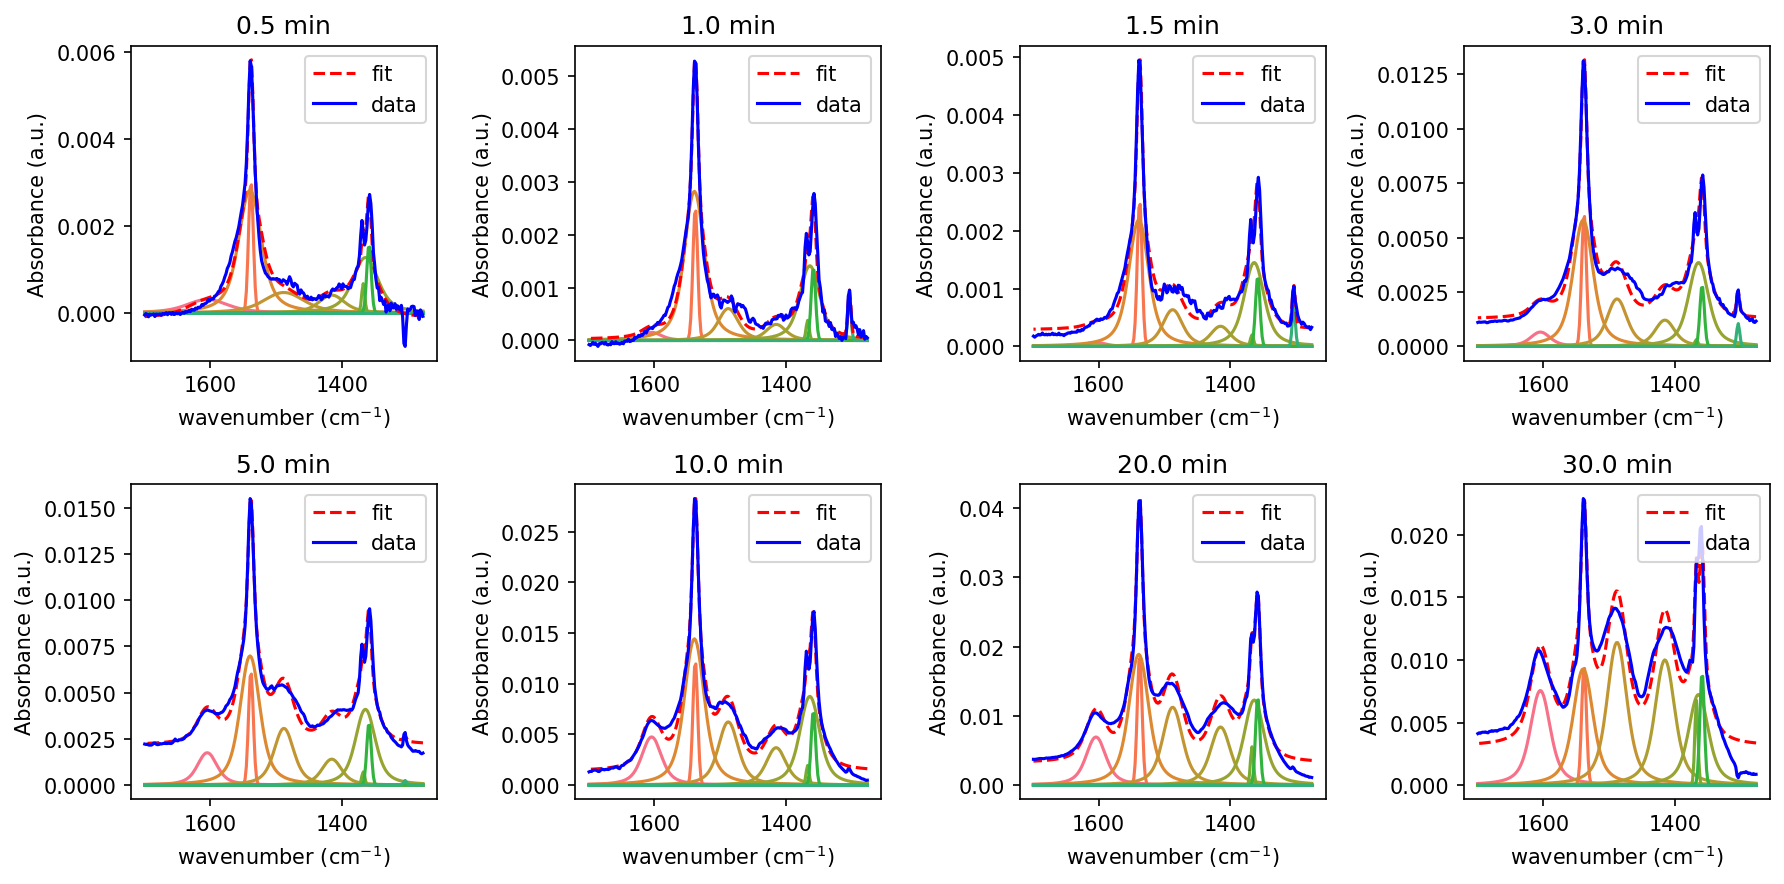

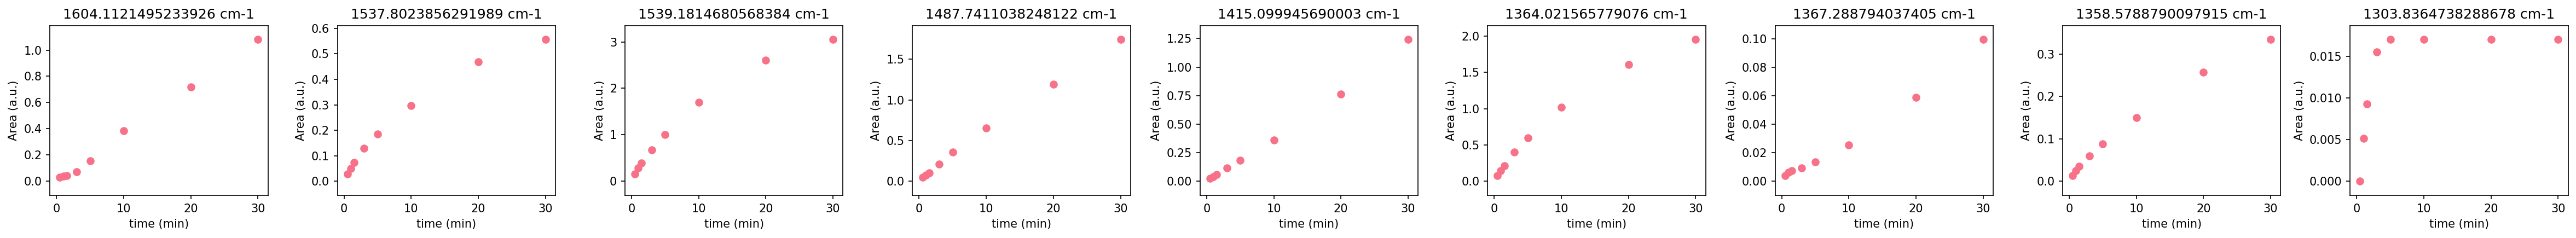

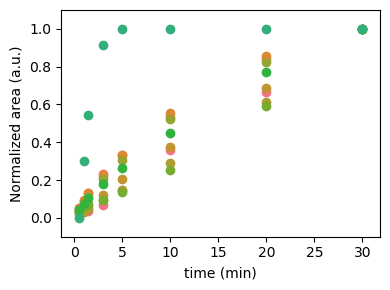

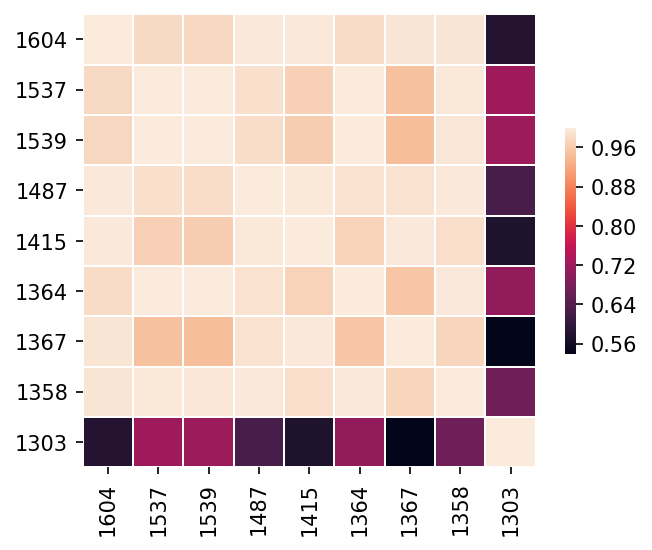

{'Peak Pos': [1604, 1537, 1539, 1487, 1415, 1364, 1367, 1358, 1303],
 'Amps': array([[3.06454128e-02, 2.75756690e-02, 1.54138326e-01, 4.57167921e-02,
         2.54645466e-02, 7.75384367e-02, 4.05181643e-03, 1.32993108e-02,
         5.55111512e-17],
        [3.79839486e-02, 5.04651907e-02, 2.89275278e-01, 7.46411514e-02,
         4.00345555e-02, 1.45266337e-01, 6.33880473e-03, 2.49646747e-02,
         5.13025294e-03],
        [4.12201954e-02, 7.34449780e-02, 3.94070903e-01, 1.05056969e-01,
         5.67223798e-02, 2.14776242e-01, 7.53932689e-03, 3.52247157e-02,
         9.28090562e-03],
        [7.27597977e-02, 1.29298959e-01, 6.72284140e-01, 2.09702514e-01,
         1.14618411e-01, 3.99558890e-01, 9.42851672e-03, 5.90516873e-02,
         1.55306201e-02],
        [1.56693603e-01, 1.85441479e-01, 1.00702249e+00, 3.56774590e-01,
         1.81968992e-01, 5.95912780e-01, 1.37208147e-02, 8.74889083e-02,
         1.70266536e-02],
        [3.84922110e-01, 2.97340886e-01, 1.69902793e+00, 6.5601

In [14]:
params_IG = result.params
Plot_data_IG(params_IG,x_CC,y_CC[:ndata],Vec_IG_CC0,time_CH[:ndata],True)

Now we want to creat a frame of the vector space, i.e. we need to define how many vectors are there and which peaks belong to which vector.

In [15]:
ndata = 8
Vec_IG_CC0 = {'Peaks':np.array([[0],[1,2],[3,4,5],[6,7],[8]]),
              'Types':np.array([[1],[0,1],[1,1,1],[0,0],[0]])}
Vec_fit_CC0 = Generate_Vec_IG(params_IG,Vec_IG_CC0,ndata)
#Vec_fit['Vec0']['Lims'] = {'Peaks':np.array([0,1,2,3]),
#                           'Specs':np.array([[0.1,0.1,0.1,0.1],
#                                            [4000,4000,4000,4000],
#                                            [0.1,.1,0.1,0.1],
#                                            [6.5,6.5,6.5,6.5]])}


In [16]:
t0 = time.time()
Vec_fit_CC0['Alphas'] = None
Vec_fit_CC0['Vec3']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[0,0],[4000,4000],[1.2,1.2],[4,4]])}
fit_params_CC0 = Generate_params(x_CC,Vec_fit_CC0,ndata =ndata)

fitter = Minimizer(loss_func, fit_params_CC0, fcn_args=(x_CC, y_CC[:ndata], Vec_fit_CC0))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

0 20.669999999999863 5.669999999999863 35.66999999999986
0 1604.1121495233926 1584.1121495233926 1624.1121495233926
1 3.6449789671375514 0.1 8.64497896713755
1 1537.8023856291989 1532.8023856291989 1542.8023856291989
1 11.4 0.1 26.4
1 1539.1814680568384 1519.1814680568384 1559.1814680568384
2 20.3 5.300000000000001 35.3
2 1487.7411038248122 1467.7411038248122 1507.7411038248122
2 12.966972008624335 0.1 27.966972008624335
2 1415.099945690003 1395.099945690003 1435.099945690003
2 12.7 0.1 27.7
2 1364.021565779076 1344.021565779076 1384.021565779076
3 2.4 1.2 4.0
3 1367.288794037405 1362.288794037405 1372.288794037405
3 3.378946795651329 1.2 4.0
3 1358.5788790097915 1353.5788790097915 1363.5788790097915
4 2.37 0.1 7.37
4 1303.8364738288678 1298.8364738288678 1308.8364738288678
The time cost is: 813.1903510093689


The score of the fit is: 0.0004986136201459962
Plotting.....


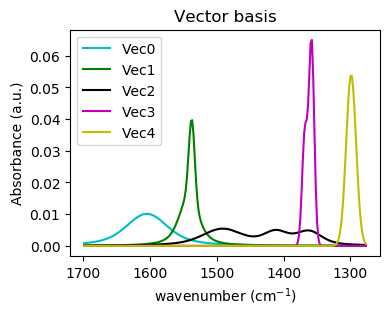

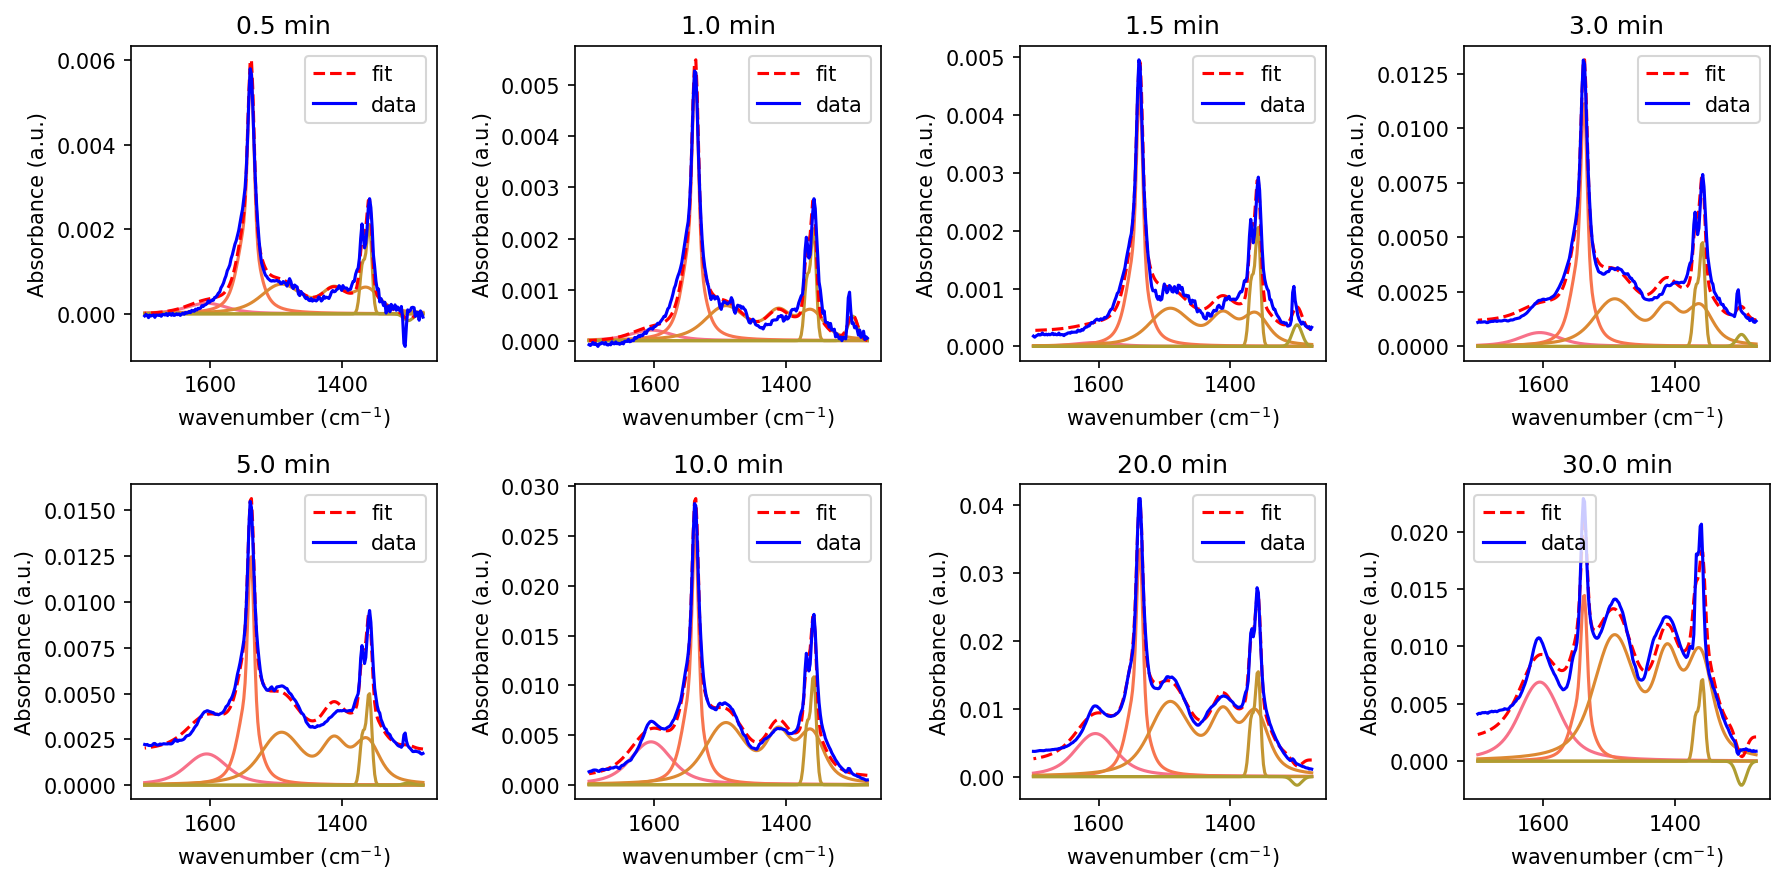

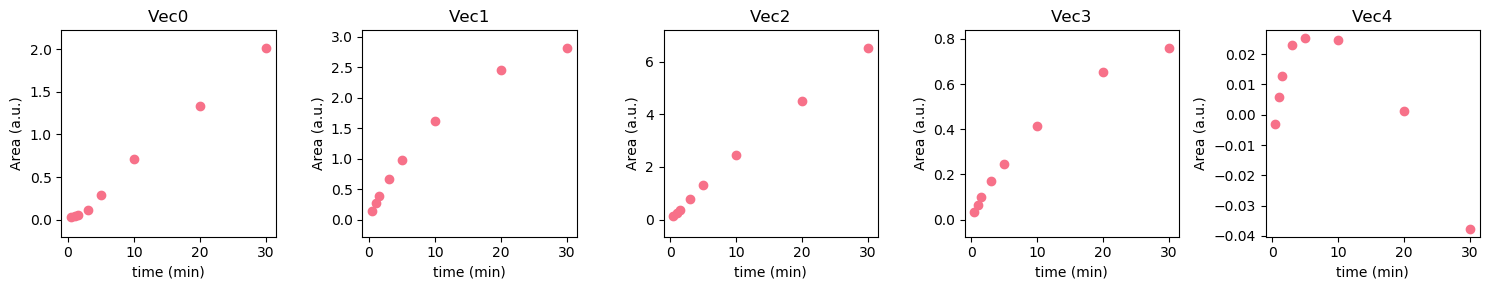

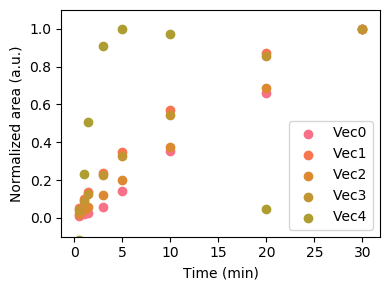

In [17]:
new_params0 = result.params
print('The score of the fit is:', result.chisqr)
Plot_data(new_params0,x_CC,y_CC[:ndata],Vec_fit_CC0,time_CH[:ndata],True)

### Fitting the Middle Stage (20,120) min

We use postfix _CC1 for fitting of this period.

Below is an intial guess of the peaks.

In [18]:
Vec_CC_IG1 = {'Mus':np.array([1605.1, 1536.8, 1559.5, 1495.7, 1415.0, 1365.2, 1367.2, 1360.3, 1303.9]),
             'Sigmas':np.array([15.0, 3.2,13.85, 11.90, 10.93, 14.42, 2.07, 3.25, 2.37]),
             'Types':np.array([1,0,1,1,1,1,0,0,0]),
             'Fixed':None,#np.array([0,0,0,0,0,0,0,1,1,1]),
             'Lims':{'Positive':False,
                     'Mus_min':np.array([1595,1537., 1500., 1460, 1370,1330, 1300, 1330, 1300.])}
             }



In [35]:
t0 = time.time()
nstart = 8
ndata = 4

fit_params_IG1 = Generate_params_IG(x_CC,Vec_CC_IG1,ndata = ndata)

fitter = Minimizer(loss_func_IG, fit_params_IG1, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_CC_IG1))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 16.49943494796753


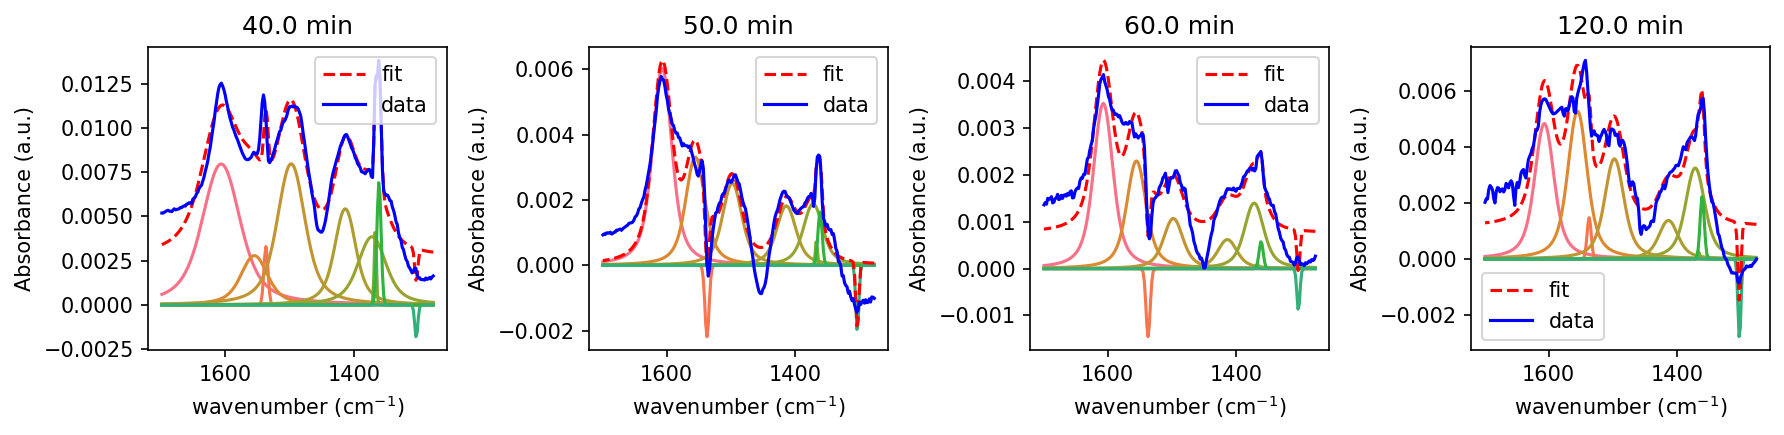

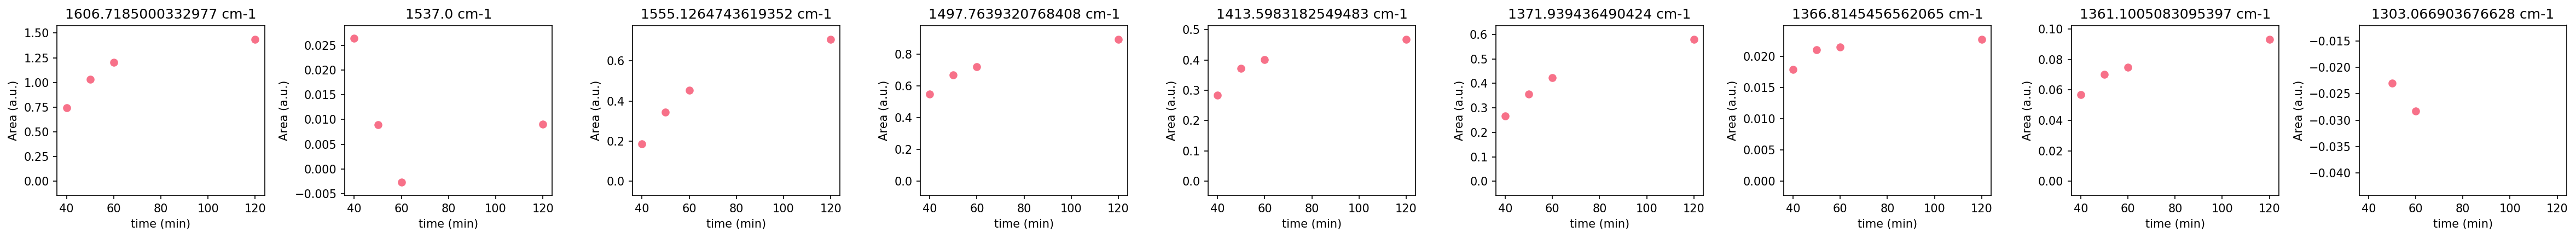

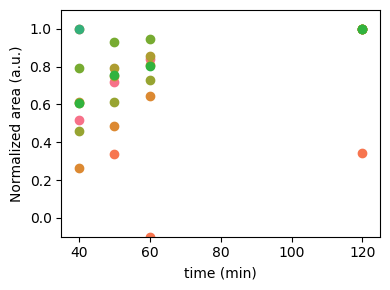

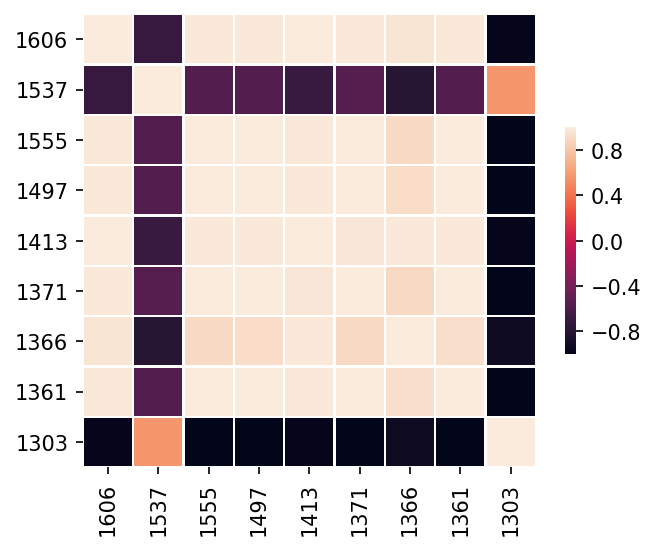

{'Peak Pos': [1606, 1537, 1555, 1497, 1413, 1371, 1366, 1361, 1303],
 'Amps': array([[ 0.74432383,  0.02644914,  0.18492276,  0.54855872,  0.28459619,
          0.26631359,  0.01793924,  0.05675826, -0.01098634],
        [ 1.03338076,  0.00890985,  0.34383283,  0.66897814,  0.37182823,
          0.35658103,  0.02106225,  0.07015774, -0.02303151],
        [ 1.20248374, -0.00274402,  0.45401268,  0.72032986,  0.40153408,
          0.42362921,  0.02149051,  0.07486402, -0.02833081],
        [ 1.43405945,  0.00907475,  0.70667468,  0.89153216,  0.46738329,
          0.57914168,  0.02269155,  0.09310268, -0.04532548]])}

In [20]:
params_IG1 = result.params
Plot_data_IG(params_IG1,x_CC,y_CC[nstart:nstart+ndata],Vec_CC_IG1,time_CH[nstart:nstart+ndata],True)

In [36]:
Vec_fit_CC1 = Generate_Vec_IG(params_IG,Vec_IG_CC0,ndata)

In [39]:
t0 = time.time()
Vec_fit_CC1['Alphas'] = None

Vec_fit_CC1['Vec3']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[1360,1360],[1370,1370],[1.2,1.2],[3.5,4]])}
fit_params_CC1 = Generate_params(x_CC,Vec_fit_CC1,ndata =ndata)
fitter = Minimizer(loss_func, fit_params_CC1, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_fit_CC1))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

0 20.669999999999863 5.669999999999863 35.66999999999986
0 1604.1121495233926 1584.1121495233926 1624.1121495233926
1 3.6449789671375514 0.1 8.64497896713755
1 1537.8023856291989 1532.8023856291989 1542.8023856291989
1 11.4 0.1 26.4
1 1539.1814680568384 1519.1814680568384 1559.1814680568384
2 20.3 5.300000000000001 35.3
2 1487.7411038248122 1467.7411038248122 1507.7411038248122
2 12.966972008624335 0.1 27.966972008624335
2 1415.099945690003 1395.099945690003 1435.099945690003
2 12.7 0.1 27.7
2 1364.021565779076 1344.021565779076 1384.021565779076
3 2.4 1.2 3.5
3 1367.288794037405 1362.288794037405 1370.0
3 3.378946795651329 1.2 4.0
3 1358.5788790097915 1360.0 1363.5788790097915
4 2.37 0.1 7.37
4 1303.8364738288678 1298.8364738288678 1308.8364738288678
The time cost is: 28.84687829017639


The score of the fit is: 0.00037359014310248367
Plotting.....


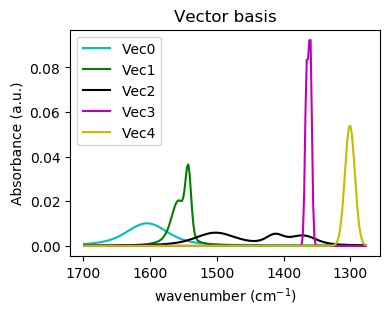

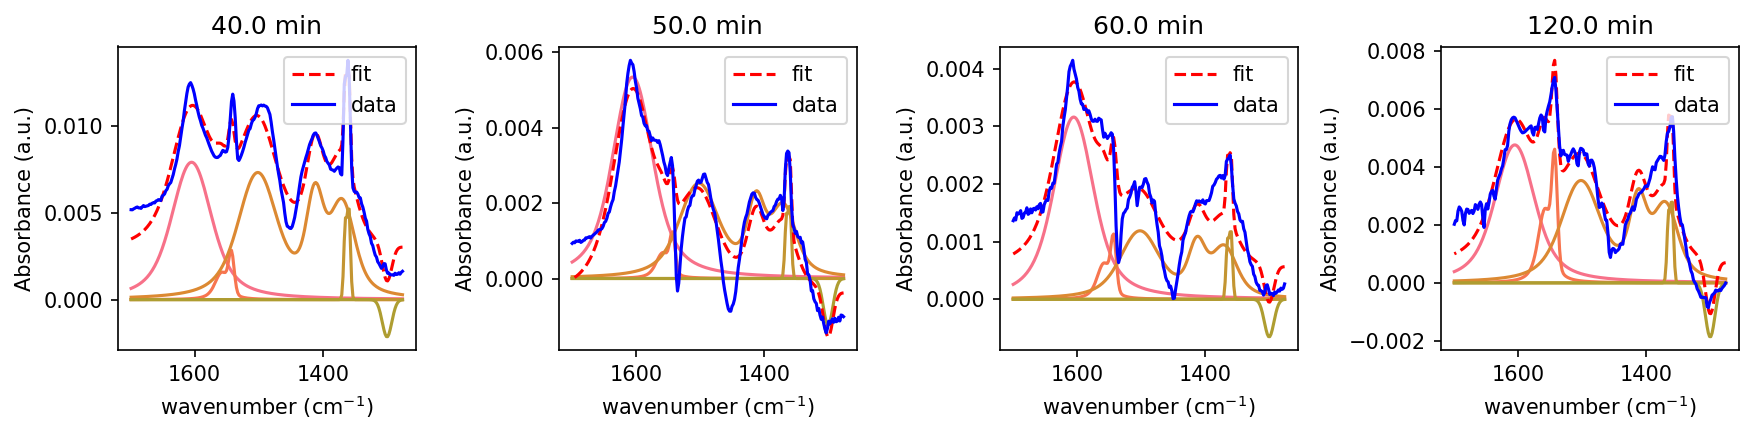

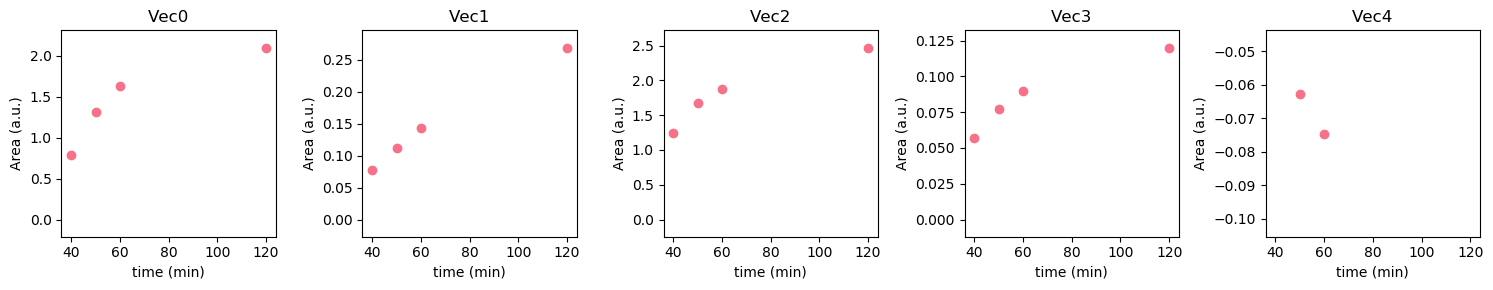

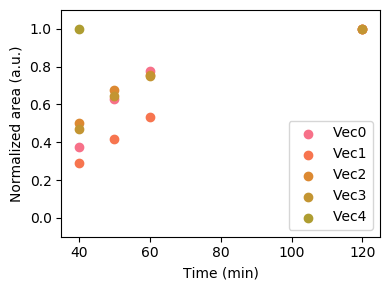

In [40]:
new_params1 = result.params
print('The score of the fit is:', result.chisqr)
Plot_data(new_params1,x_CC,y_CC[nstart:nstart+ndata],Vec_fit_CC1,time_CH[nstart:nstart+ndata],True)

### Fitting the Final Stage (180,720) min

We use postfix _CC2 for fitting of this period.

Below is an intial guess of the peaks.

In [24]:
Vec_IG_CC2 = {'Mus':np.array([1600, 1537.8, 1541.7, 1473.6, 1386, 1352, 1369.1, 1357.9, 1303.9]),
             'Sigmas':np.array([15.9, 4.4,18.7, 20, 18, 8.7, 2.4, 4, 2.37]),
             'Types':np.array([0,1,0,0,0,0,1,1,1]),
             'Fixed':None,#np.array([0,0,0,0,0,0,0,1,1,1]),
             'Lims':{'Positive':False,
                     'Mus_min':np.array([1595,1537., 1500., 1460, 1370,1330, 1300, 1330, 1300.])}
             }


In [34]:
t0 = time.time()
nstart = 12
ndata = 6
fit_params_IG2 = Generate_params_IG(x_CC,Vec_IG_CC2,ndata = ndata)
fitter = Minimizer(loss_func_IG, fit_params_IG2, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_IG_CC2))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 34.529746770858765


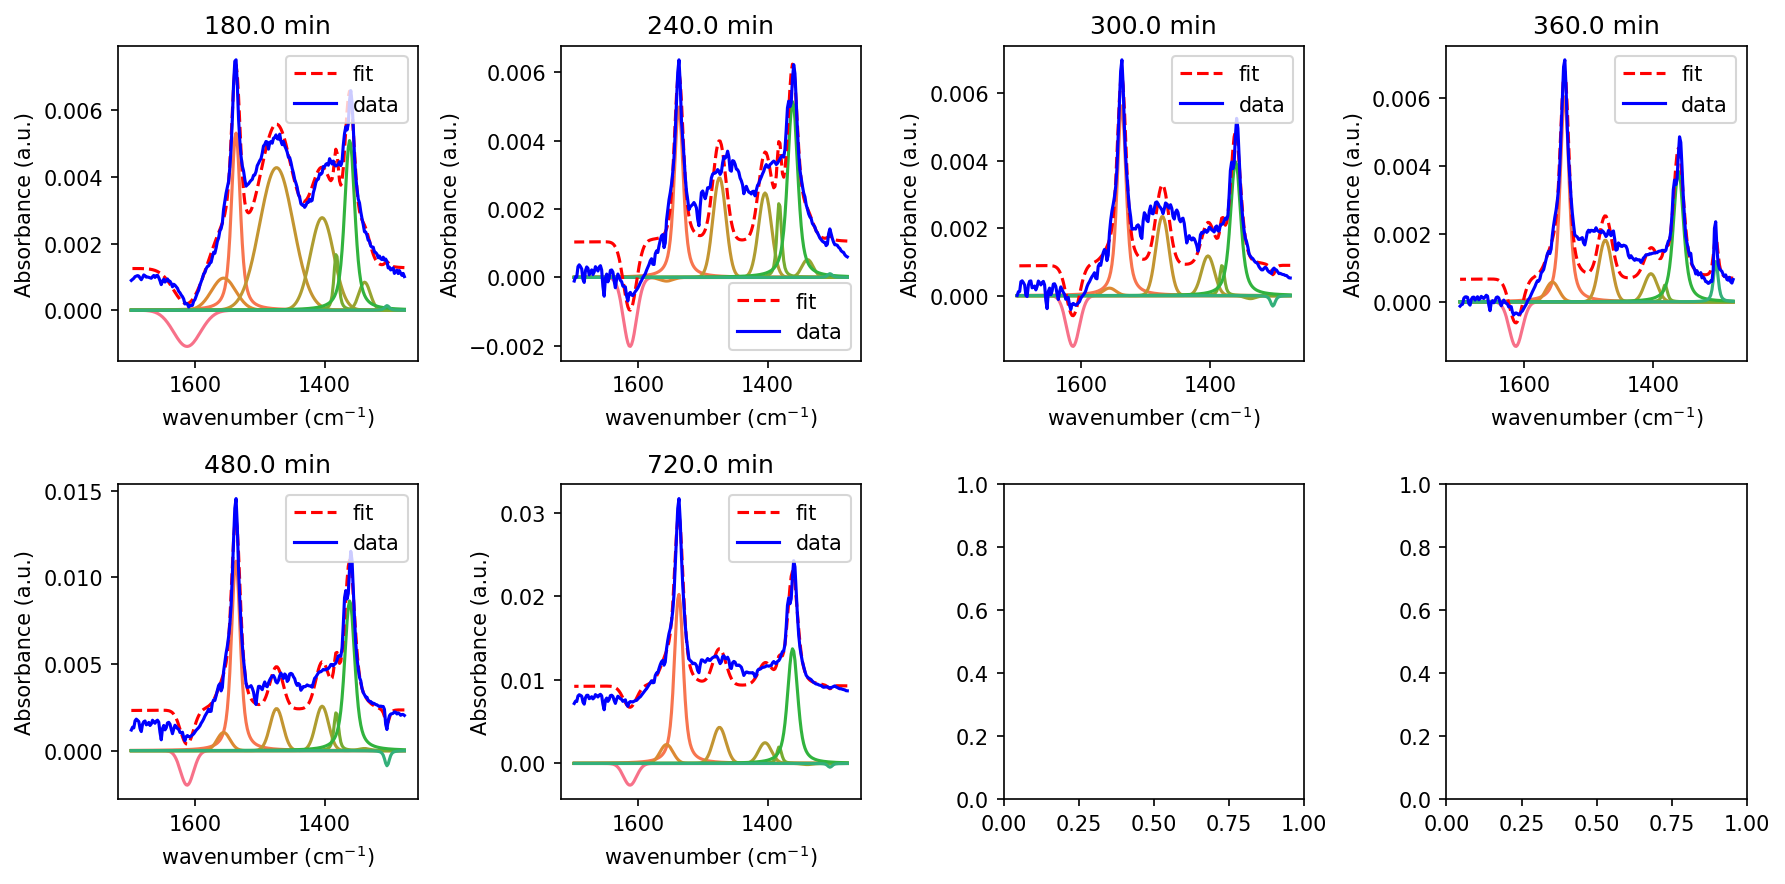

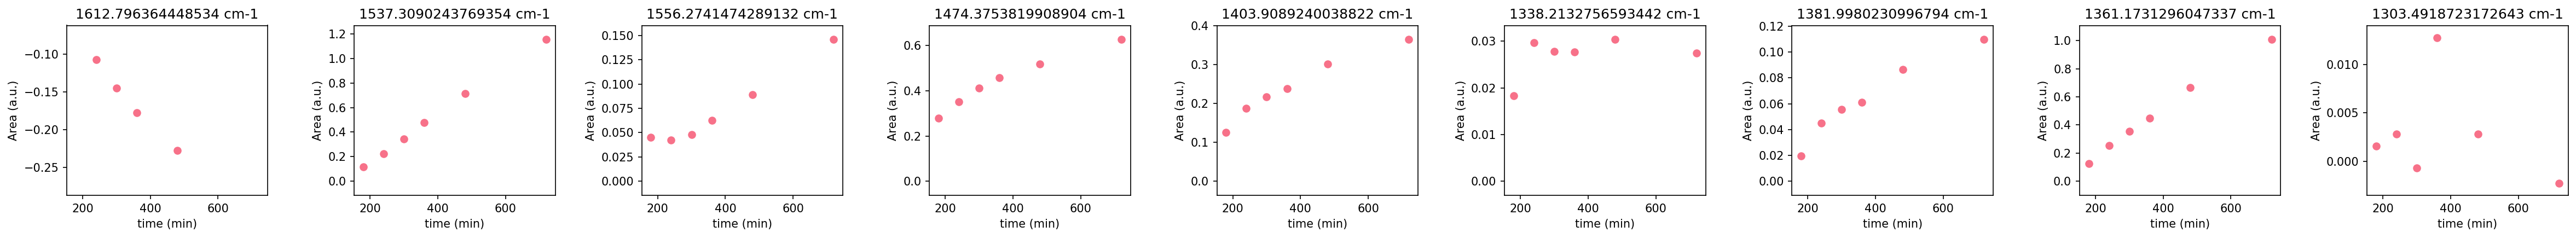

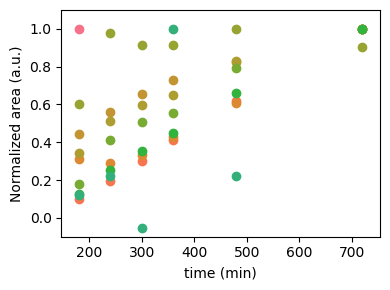

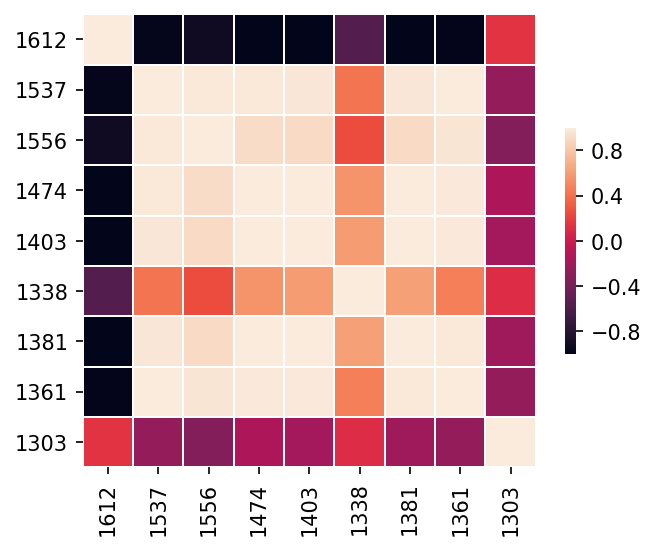

{'Peak Pos': [1612, 1537, 1556, 1474, 1403, 1338, 1381, 1361, 1303],
 'Amps': array([[-5.63152398e-02,  1.15455566e-01,  4.52060819e-02,
          2.79109619e-01,  1.25453004e-01,  1.83672743e-02,
          1.96380635e-02,  1.27050595e-01,  1.57240658e-03],
        [-1.06960260e-01,  2.23585364e-01,  4.25153531e-02,
          3.52206495e-01,  1.87341091e-01,  2.97315724e-02,
          4.49733981e-02,  2.55246759e-01,  2.81408488e-03],
        [-1.44750635e-01,  3.45667586e-01,  4.80803550e-02,
          4.11127882e-01,  2.16859004e-01,  2.77780534e-02,
          5.54175494e-02,  3.54295135e-01, -7.09011782e-04],
        [-1.77672593e-01,  4.76667667e-01,  6.26907151e-02,
          4.56711832e-01,  2.37656792e-01,  2.77479403e-02,
          6.11550442e-02,  4.50176381e-01,  1.27731213e-02],
        [-2.27700625e-01,  7.13843753e-01,  8.89033235e-02,
          5.17531941e-01,  3.01886468e-01,  3.03624553e-02,
          8.67403899e-02,  6.65424935e-01,  2.82944950e-03],
        [-2.929614

In [26]:
params_IG2 = result.params
Plot_data_IG(params_IG2,x_CC,y_CC[nstart:nstart+ndata],Vec_IG_CC2,time_CH[nstart:nstart+ndata],True)

In [27]:
Vec_fit_CC2 = Generate_Vec_IG(params_IG2,Vec_IG_CC0,ndata)

In [32]:
t0 = time.time()
Vec_fit_CC2['Vec3']['Mus'][0]=1365.5
Vec_fit_CC2['Alphas'] = None
Vec_fit_CC2['Vec0']['Lims'] = {'Peaks':np.array([0]),'Specs':np.array([[0],[4000],[10],[18]])}
Vec_fit_CC2['Vec3']['Lims'] = {'Peaks':np.array([0,1]),'Specs':np.array([[1350,1350],[1370,1370],[1.2,1.2],[3.5,4]])}

fit_params_CC2 = Generate_params(x_CC,Vec_fit_CC2,ndata=ndata)

fitter = Minimizer(loss_func, fit_params_CC2, fcn_args=(x_CC, y_CC[nstart:nstart+ndata], Vec_fit_CC0))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

0 20.669999470555247 10 18
0 1612.796364448534 1592.796364448534 1632.796364448534
1 4.5254008877353975 0.1 9.525400887735398
1 1537.3090243769354 1532.3090243769354 1542.3090243769354
1 18.7 3.6999999999999993 33.7
1 1556.2741474289132 1536.2741474289132 1576.2741474289132
2 25.99999999999999 10.99999999999999 40.999999999999986
2 1474.3753819908904 1454.3753819908904 1494.3753819908904
2 18.0 3.0 33.0
2 1403.9089240038822 1383.9089240038822 1423.9089240038822
2 8.7 0.1 23.7
2 1338.2132756593442 1318.2132756593442 1358.2132756593442
3 2.4 1.2 3.5
3 1365.5 1360.5 1370.0
3 5.199999999999999 1.2 4.0
3 1361.1731296047337 1356.1731296047337 1366.1731296047337
4 2.37 0.1 7.37
4 1303.4918723172643 1298.4918723172643 1308.4918723172643
The time cost is: 2.1321489810943604


The score of the fit is: 1.922141402053339e-07
Plotting.....


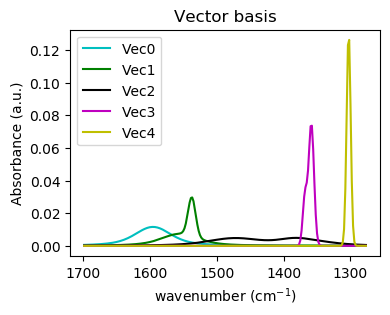

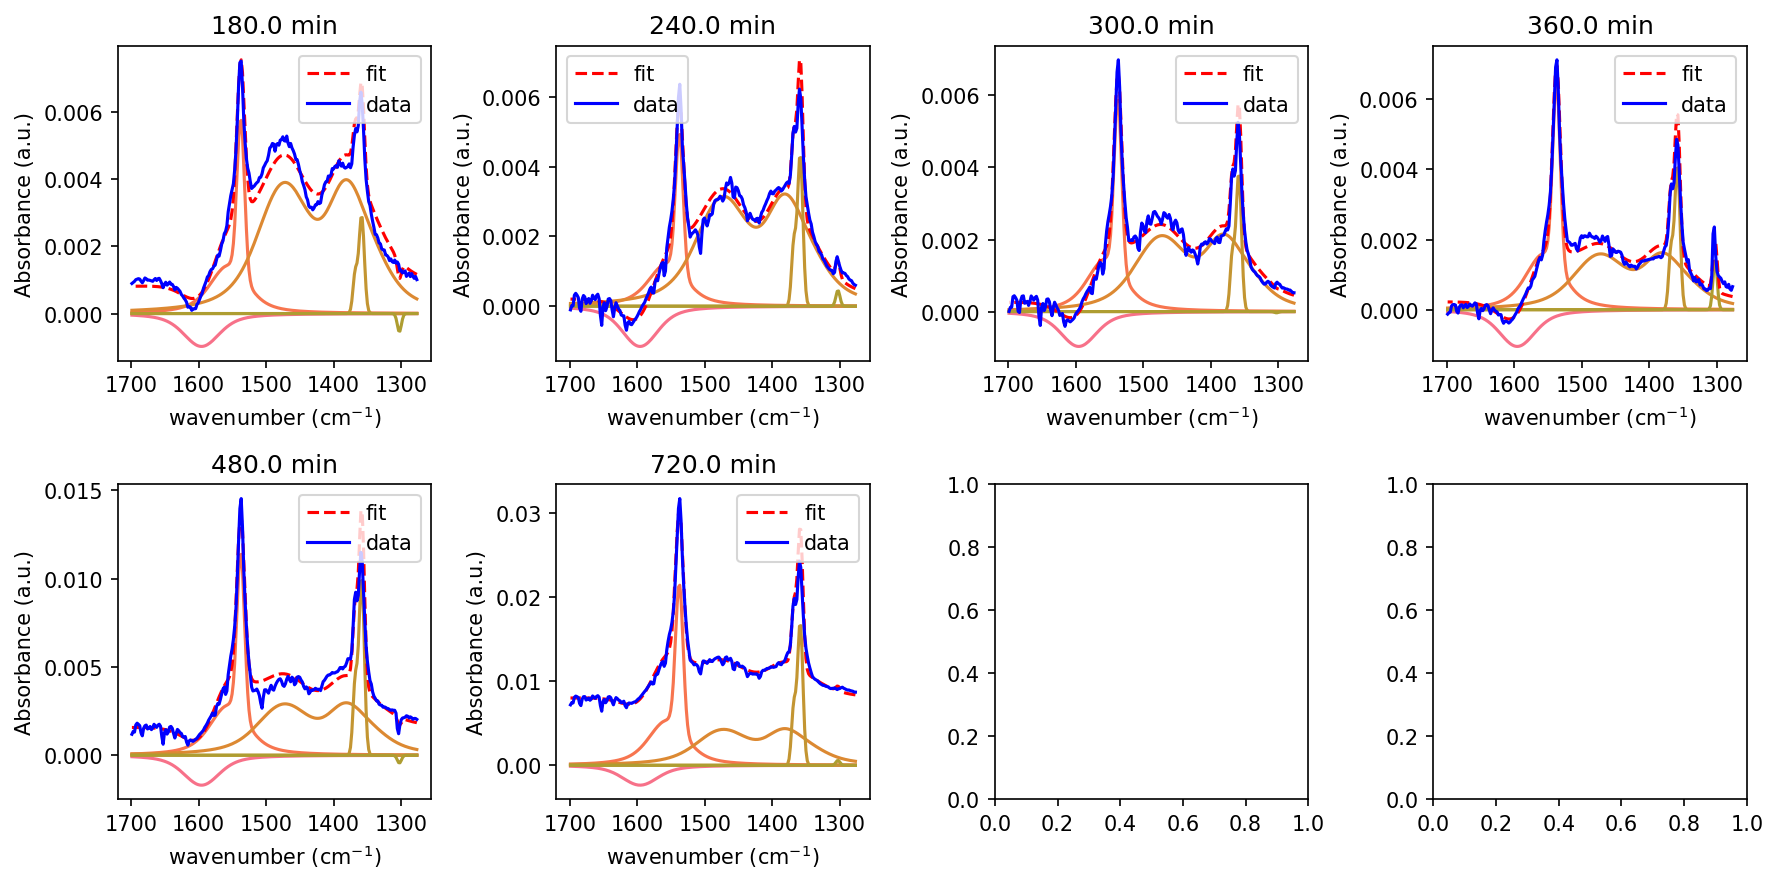

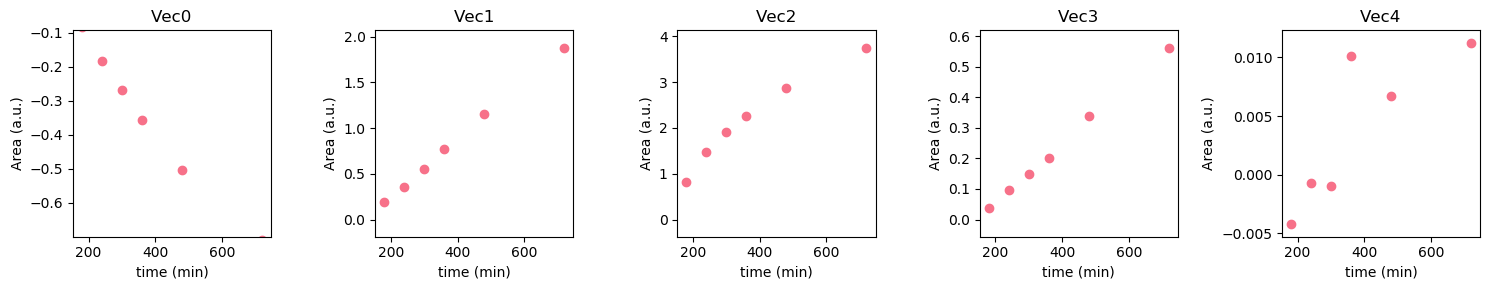

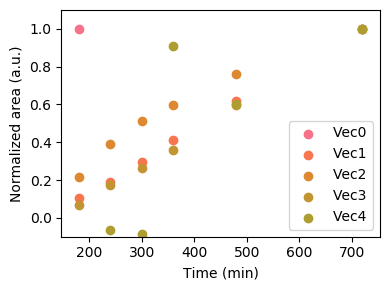

In [33]:
new_params2 = result.params
print('The score of the fit is:', result.redchi)
Plot_data(new_params2,x_CC,y_CC[nstart:nstart+ndata],Vec_fit_CC2,time_CH[nstart:nstart+ndata],True)

In [200]:
import lmfit
lmfit.printfuncs.report_fit(new_params)

[[Variables]]
    lin_0:     3.3034e-04 +/- 9.1725e-05 (27.77%) (init = 0)
    amp_000:   0.00997648 +/- 0.00444257 (44.53%) (init = 0.003991685)
    cen_000:   2862.18084 +/- 1.53248535 (0.05%) (init = 2862.42)
    sig_000:   6.04901926 +/- 0.42939078 (7.10%) (init = 6.158791)
    amp_001:   0.00289750 +/- 0.00114275 (39.44%) (init = 0.001306746)
    cen_001:   2951.93841 +/- 0.16216981 (0.01%) (init = 2952)
    sig_001:   3.19970366 +/- 0.13554001 (4.24%) (init = 3.6)
    amp_002:   0.00339278 +/- 0.00225857 (66.57%) (init = 0.001541984)
    cen_002:   2852.70223 +/- 0.76918241 (0.03%) (init = 2853.1)
    sig_002:   3.88746853 +/- 0.58921186 (15.16%) (init = 4.1)
    amp_003:   0.00989774 +/- 0.00388580 (39.26%) (init = 0.004059495)
    cen_003:   2934.33410 +/- 0.04140465 (0.00%) (init = 2934.306)
    sig_003:   2.93106940 +/- 0.03409257 (1.16%) (init = 2.918849)
    lin_1:     1.9194e-04 +/- 9.1749e-05 (47.80%) (init = 0)
    amp_100:   0.01393095 +/- 0.00488934 (35.10%) (init = 0.

array([[ 2.48412643e-02,  4.52917395e-02,  5.18763536e-02,
         1.14680788e-01,  2.83462882e-01,  7.11019655e-01,
         1.34020365e+00,  2.02259103e+00,  2.80852334e+00,
         3.33762813e+00,  3.65057867e+00,  4.12169115e+00,
         4.03718717e+00,  3.93769132e+00,  3.85420249e+00,
         3.76387442e+00,  3.61758403e+00,  3.41352381e+00],
       [ 1.44848401e-01,  2.77241704e-01,  3.88177119e-01,
         6.68823506e-01,  9.83278435e-01,  1.61677663e+00,
         2.46238247e+00,  2.82637195e+00,  2.90441211e+00,
         2.93832977e+00,  2.96932438e+00,  3.09556472e+00,
         3.28971686e+00,  3.45569734e+00,  3.65352377e+00,
         3.87061007e+00,  4.25458278e+00,  4.97705167e+00],
       [ 1.29740193e-01,  2.56146561e-01,  3.77658359e-01,
         7.79663832e-01,  1.31189684e+00,  2.46434192e+00,
         4.50839624e+00,  6.53837876e+00,  7.78347834e+00,
         8.21172132e+00,  8.41301284e+00,  9.01152951e+00,
         9.82923379e+00,  1.04885357e+01,  1.09297676e

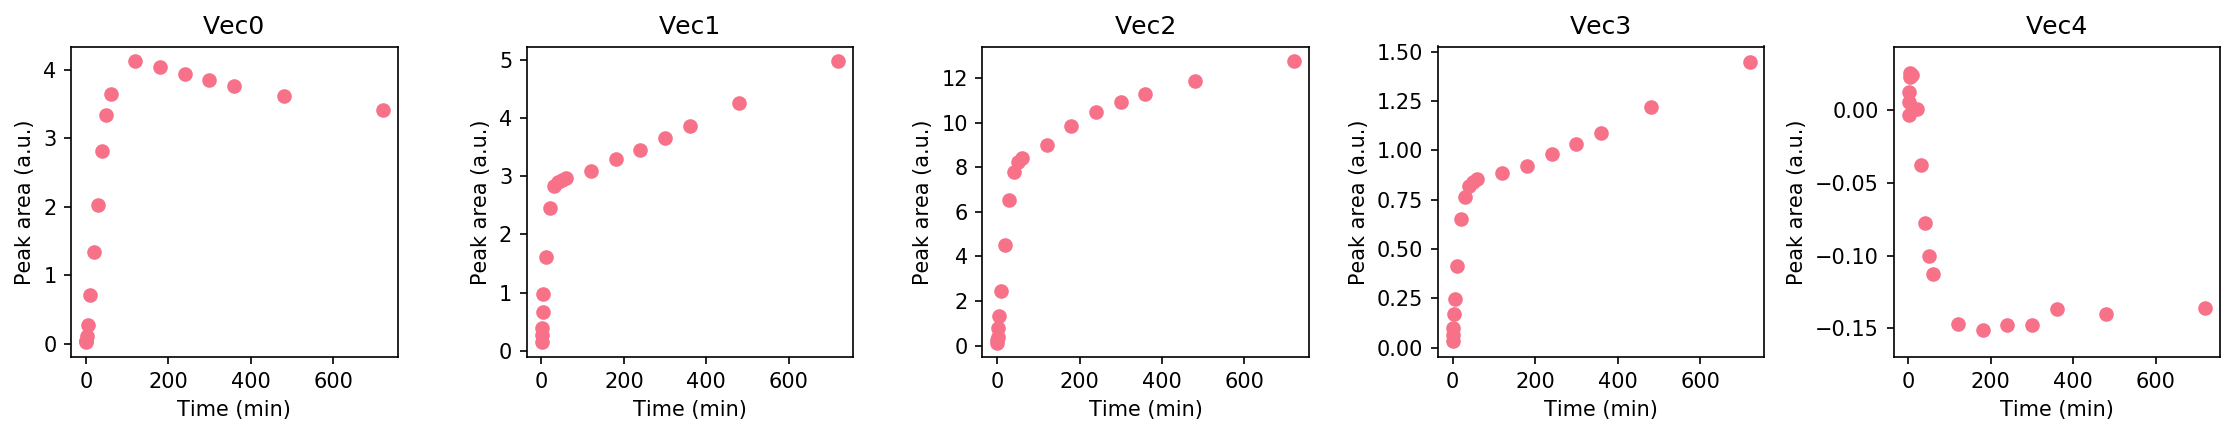

In [41]:
Param_com = {'Params': (new_params0,new_params1,new_params2) ,
            'Lens':np.array([8,4,6])}
Plot_com_data(Param_com,Vec_IG_CC0,Time[:18],True)

## Fitting the 1000 - 1300 cm$^{-1}$ region

This region contains charistic peaks from C-O speices. 

In [225]:
Vec_IG_CO = {'Mus':np.array([1086.8, 1219.9, 1200.2]),
          'Sigmas':np.array([13.8,3.6,17.3]),
          'Types':np.array([1,0,1]),
          'Fixed':None,
          'Lims':None}


In [229]:
t0 = time.time()
fit_params_IG_CO = Generate_params_IG(x_CO,Vec_IG_CO,ndata =18)

fitter = Minimizer(loss_func_IG, fit_params_IG_CO, fcn_args=(x_CO, y_CO, Vec_IG_CO))
result = fitter.minimize(method='leastsq')
t1 = time.time() 

print('The time cost is:',t1-t0)

The time cost is: 3.8521502017974854


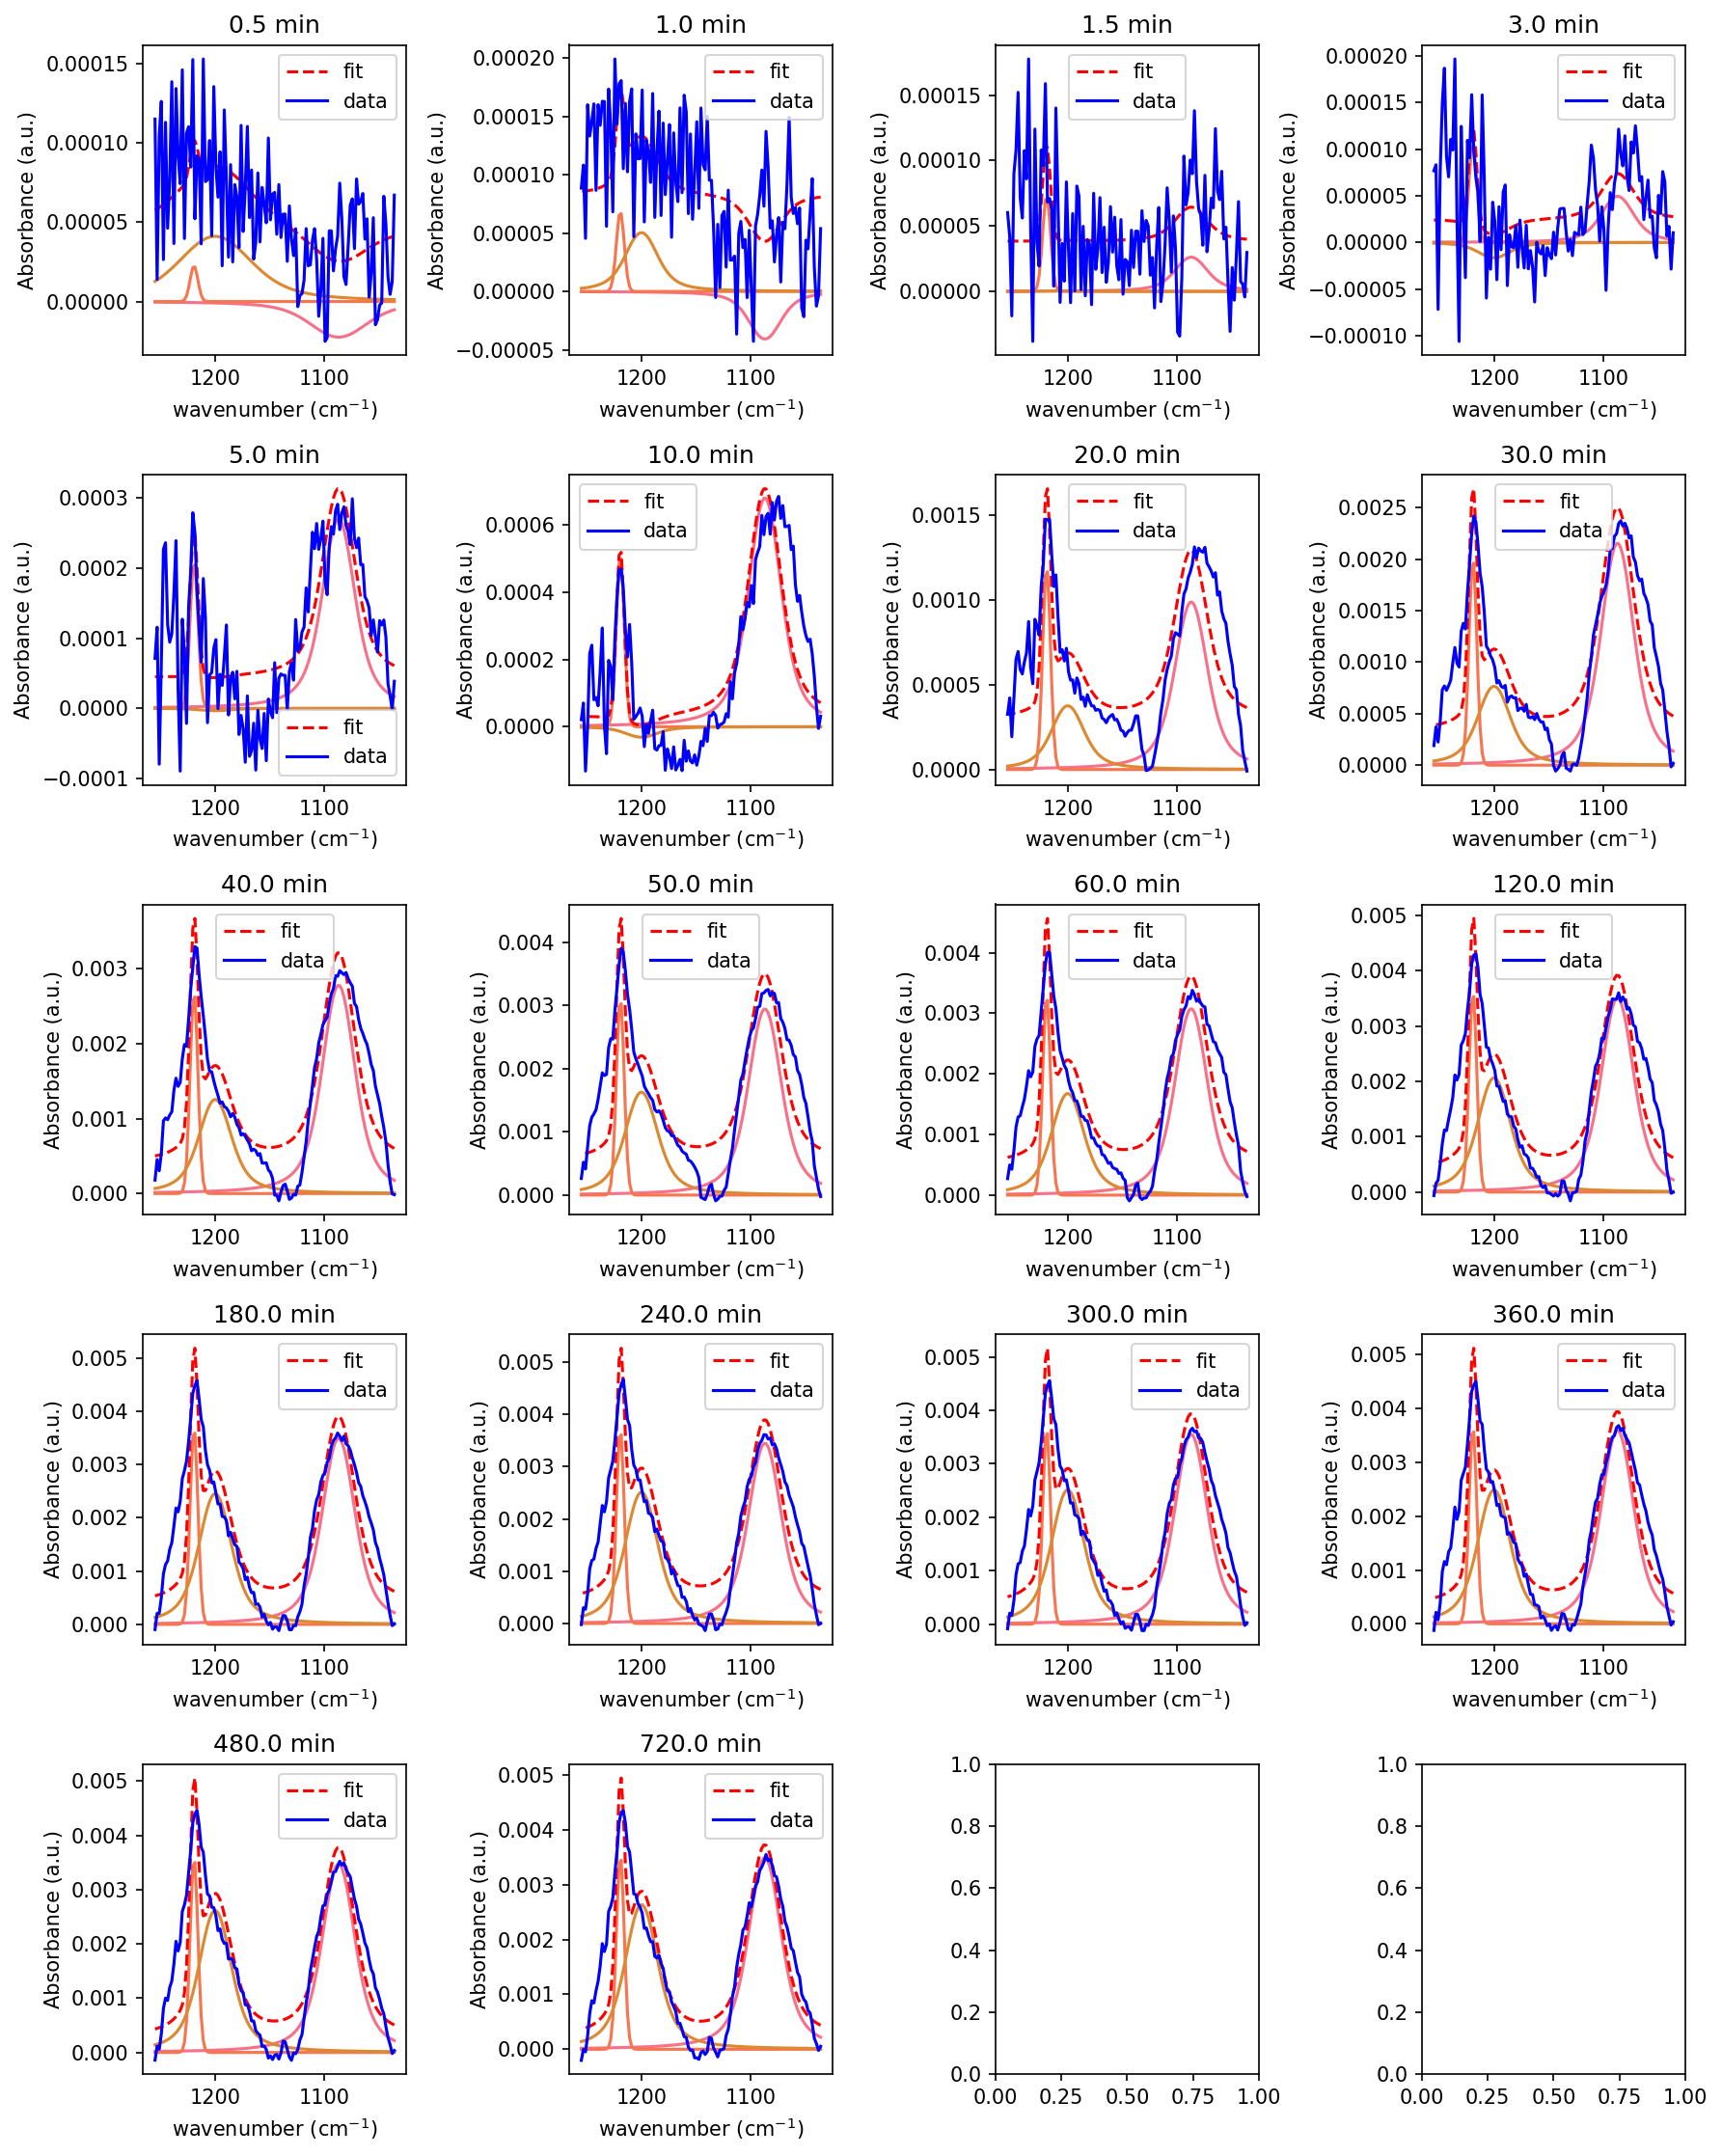

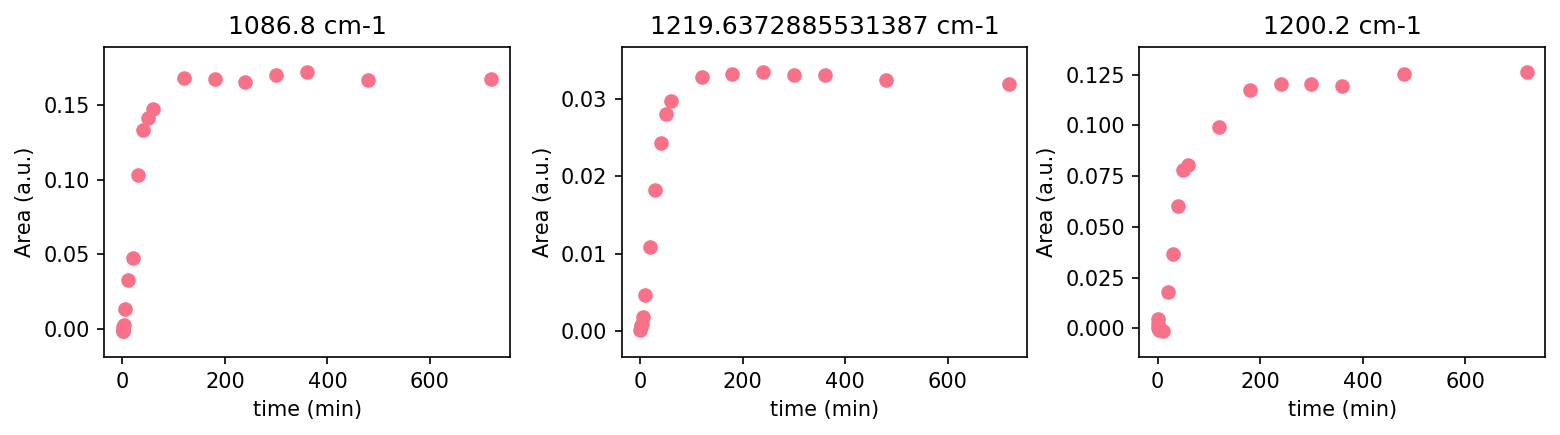

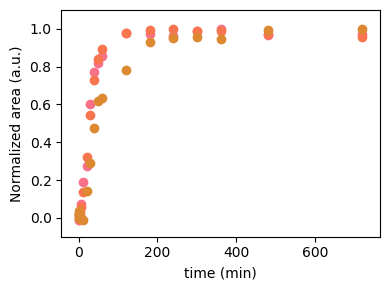

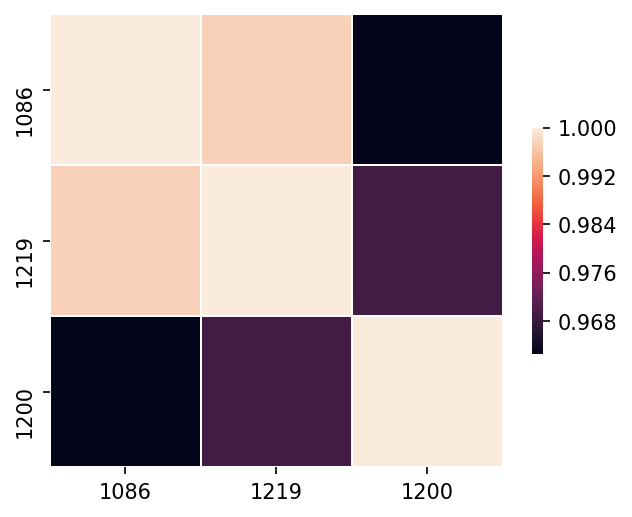

{'Peak Pos': [1086, 1219, 1200],
 'Amps': array([[-1.92770814e-03,  2.02110127e-04,  4.42774951e-03],
        [-1.95406067e-03,  6.18333284e-04,  2.41834096e-03],
        [ 1.25325111e-03,  6.61495224e-04,  2.31234189e-05],
        [ 2.37357661e-03,  9.65743593e-04, -7.84471523e-04],
        [ 1.29189139e-02,  1.89688937e-03, -1.55487896e-04],
        [ 3.25463895e-02,  4.61152835e-03, -1.48527249e-03],
        [ 4.74205324e-02,  1.08187303e-02,  1.80385734e-02],
        [ 1.03331988e-01,  1.81748033e-02,  3.66996168e-02],
        [ 1.33211119e-01,  2.43036439e-02,  6.01407073e-02],
        [ 1.41100755e-01,  2.80562936e-02,  7.81073890e-02],
        [ 1.47448754e-01,  2.97936611e-02,  8.03565450e-02],
        [ 1.68260363e-01,  3.27751676e-02,  9.90277775e-02],
        [ 1.67376643e-01,  3.32622005e-02,  1.17599965e-01],
        [ 1.65234169e-01,  3.34285914e-02,  1.20397150e-01],
        [ 1.70140216e-01,  3.30379678e-02,  1.20528812e-01],
        [ 1.72103877e-01,  3.30478759e-02,  

In [230]:
params_IG_CO = result.params
Plot_data_IG(params_IG_CO,x_CO,y_CO,Vec_IG_CO,time_CH[:18],False)

In [231]:
Vec_IG_struc_CO = {'Peaks':[[0,1,2]],'Types':[[1,0,1]]}
Vec_fit_CO = Generate_Vec_IG(params_IG_CO,Vec_IG_struc_CO,18)
#Vec_fit['Vec0']['Lims'] = {'Peaks':np.array([0,1,2,3]),
 #                          'Specs':np.array([[0.1,0.1,0.1,0.1],
 #                                           [4000,4000,4000,4000],
 #                                           [0.1,.1,0.1,0.1],
  #                                          [6.5,6.5,6.5,6.5]])}


In [236]:
t0 = time.time()
fit_params_CO = Generate_params(x_CO,Vec_fit_CO,ndata = 18)

fitter = Minimizer(loss_func, fit_params_CO, fcn_args=(x_CO, y_CO, Vec_fit_CO))
result = fitter.minimize(method='leastsq')
t1 = time.time()

print('The time cost is:',t1-t0)

0 17.939992989754735 2.939992989754735 32.939992989754735
0 1086.8 1066.8 1106.8
0 3.6 0.1 8.6
0 1219.6372885531387 1214.6372885531387 1224.6372885531387
0 22.488200855990666 7.488200855990666 37.48820085599067
0 1200.2 1180.2 1220.2
The time cost is: 3.453878879547119


In [237]:
new_params_CO = result.params
report_fit(new_params_CO)

[[Variables]]
    lin_0:     4.1530e-05 (init = 0)
    amp_000:   0.00177508 (init = 0.0002694341)
    cen_000:   1081.56587 (init = 1086.8)
    sig_000:   18.1215028 (init = 17.93999)
    amp_001:   1.0950e-04 (init = 5.254189e-05)
    cen_001:   1218.69210 (init = 1219.637)
    sig_001:   6.04159971 (init = 3.6)
    amp_002:   0.00180313 (init = 0.0001660988)
    cen_002:   1212.43166 (init = 1200.2)
    sig_002:   22.4882009 (init = 22.4882)
    lin_1:     7.1113e-05 (init = 0)
    amp_100:   0.00222143 (init = 0.0001079484)
    cen_100:   1081.56587 == 'cen_000'
    sig_100:   18.1215028 == 'sig_000'
    amp_101:   1.3703e-04 == 'amp_100*amp_001/amp_000'
    cen_101:   1218.69210 == 'cen_001'
    sig_101:   6.04159971 == 'sig_001'
    amp_102:   0.00225653 == 'amp_100*amp_002/amp_000'
    cen_102:   1212.43166 == 'cen_002'
    sig_102:   22.4882009 == 'sig_002'
    lin_2:     8.8704e-06 (init = 0)
    amp_200:   0.00496416 (init = 0.0001932268)
    cen_200:   1081.56587 == 'cen_000

Plotting.....


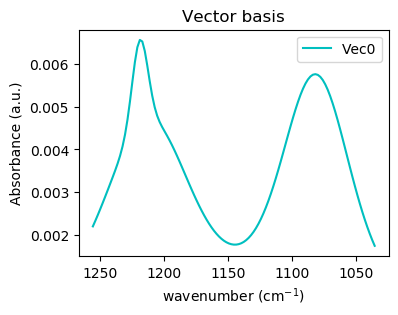

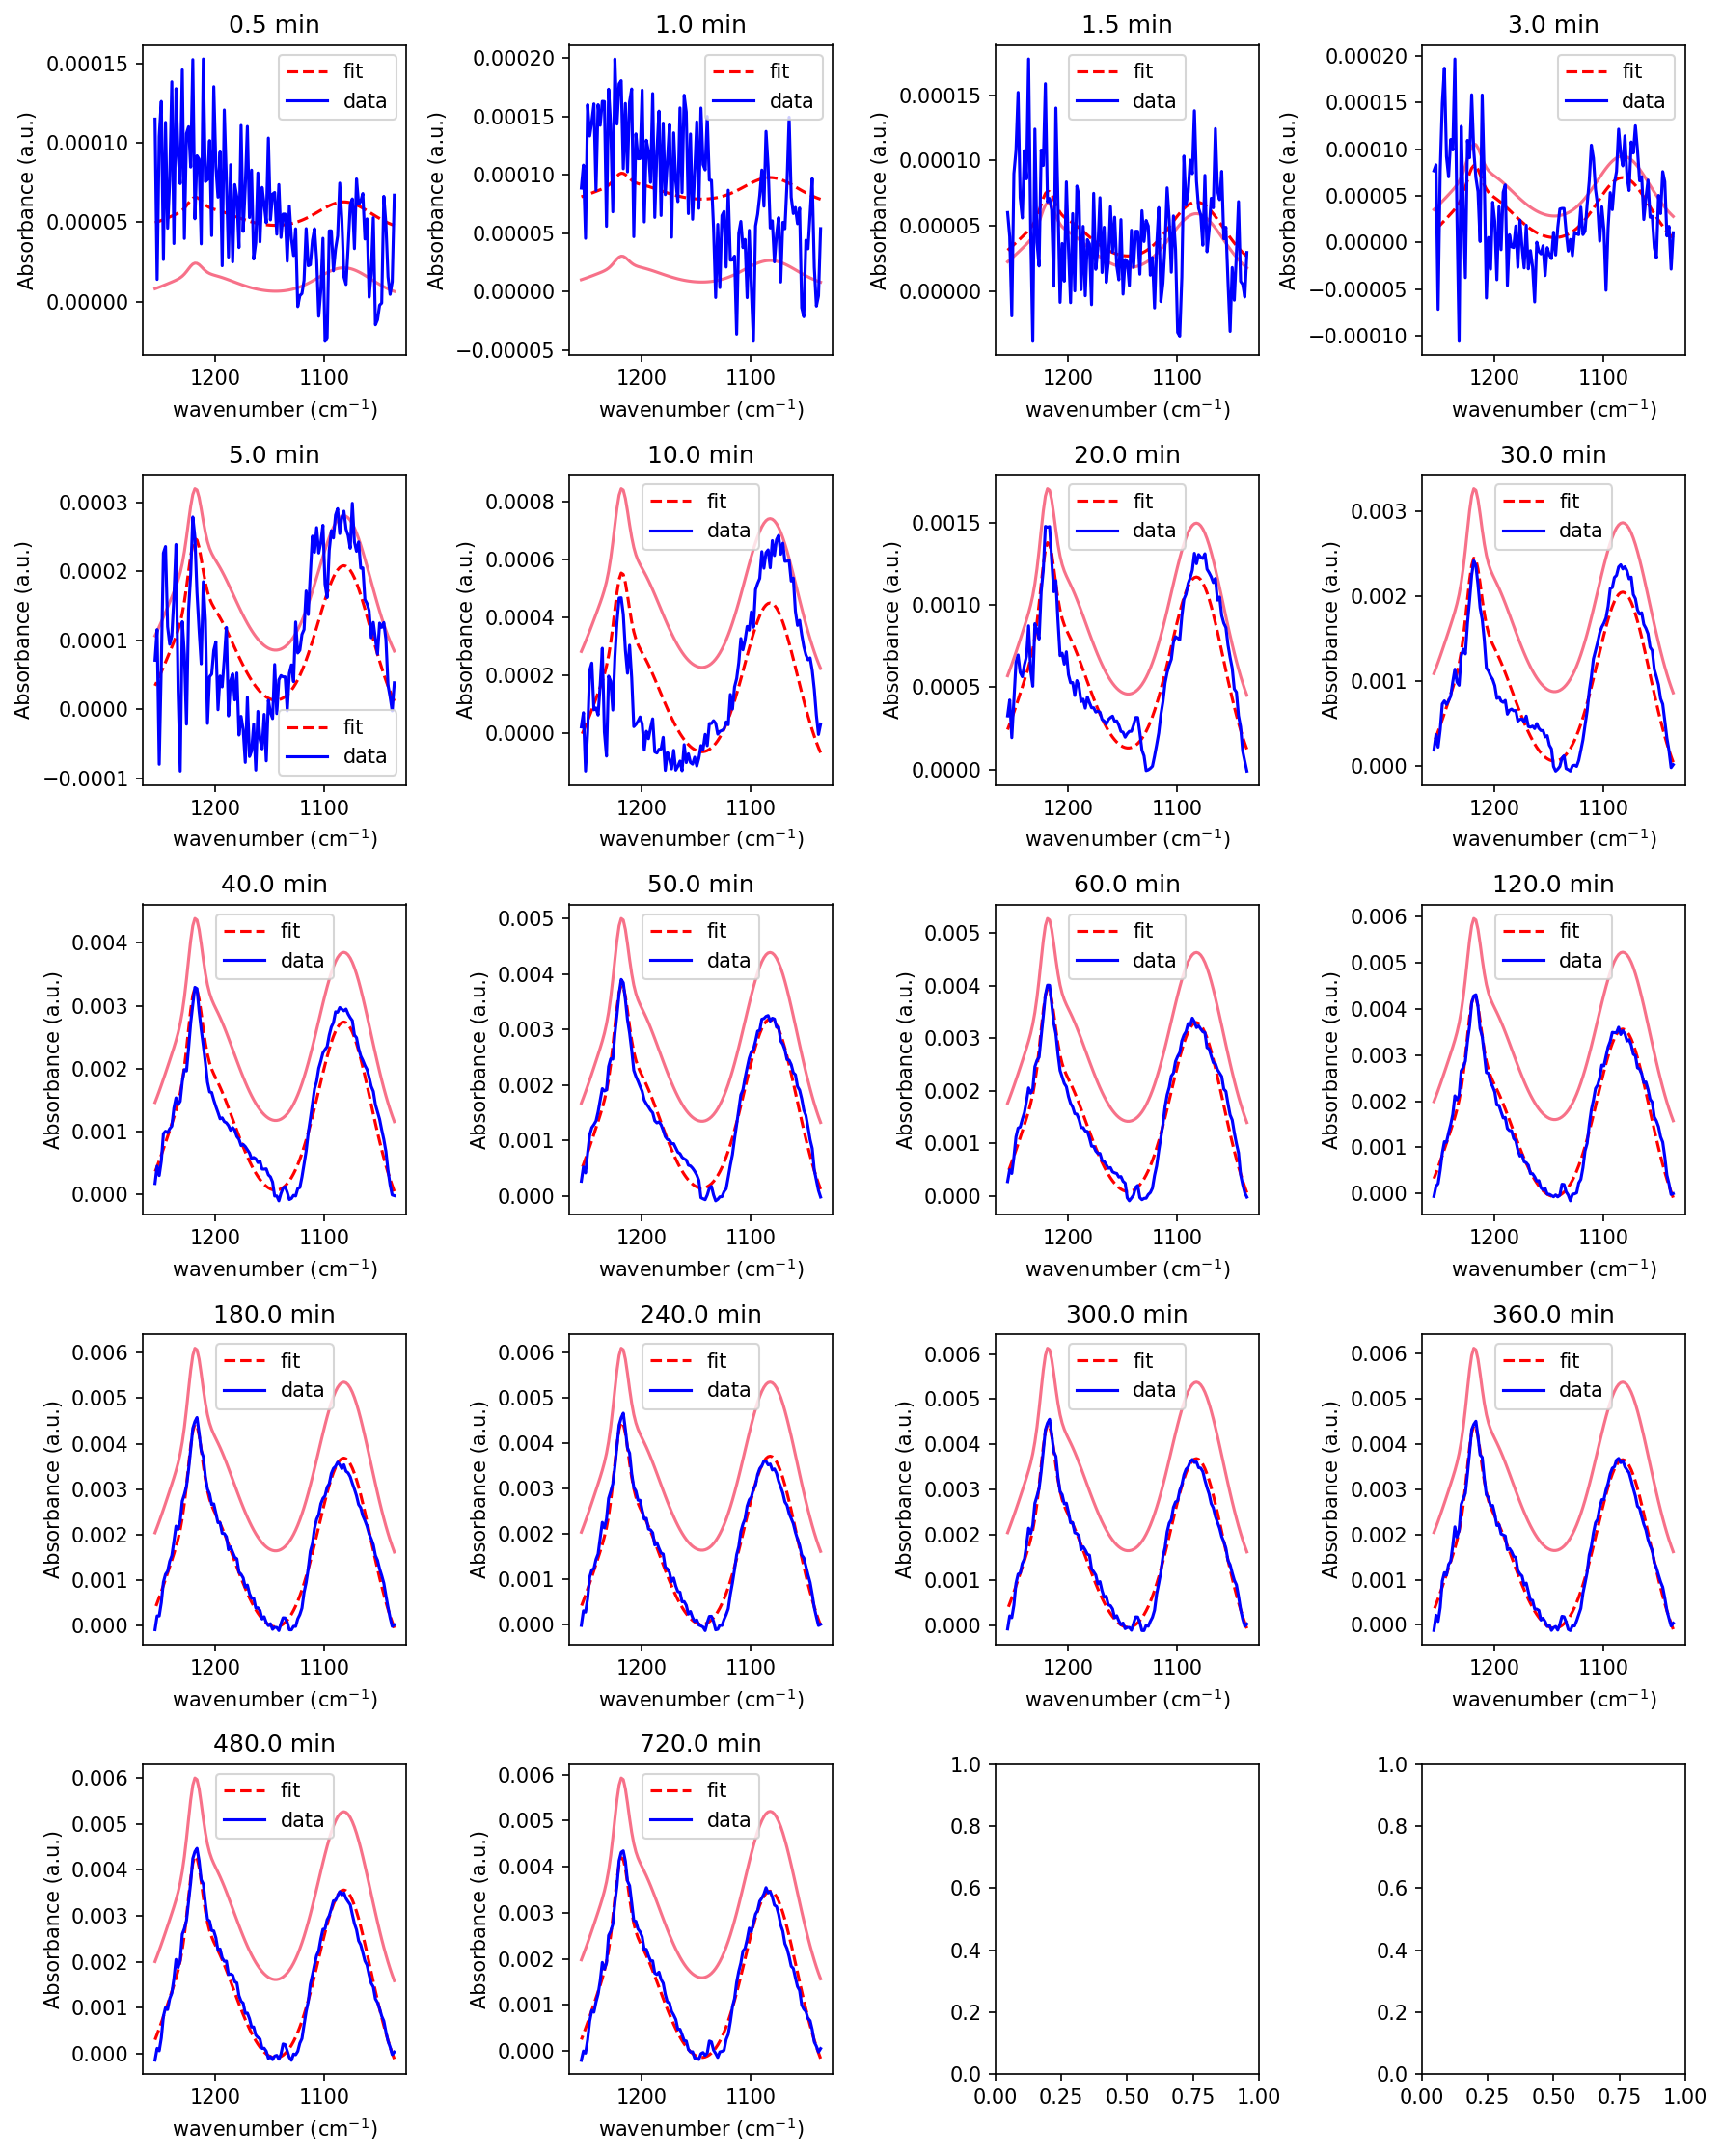

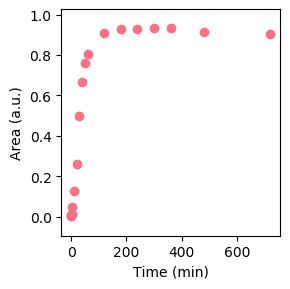

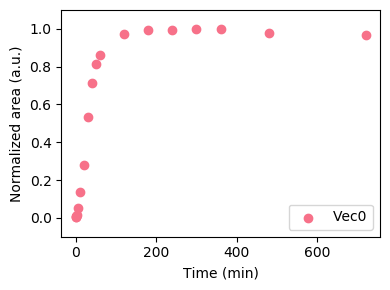

In [238]:
Plot_data(new_params_CO,x_CO,y_CO,Vec_fit_CO,time_CH[:18],False)

In [193]:
def Print_var(Param,Name,Vec,Assignment=None):
    print('Species\t\tType\t\tPeak (cm-1)\terror(%)\tVariance (cm-1)\terror(%)')
    nVec = len(Name)
    data = np.zeros((nVec,len(Time)))
    for j in range(nVec):
        print(Name[j], end='\t')
        nPeak = len(Vec['Peaks'][j])
        for k in range(nPeak):
            if k != 0:
                print('\t',end='\t')
            if Vec['Types'][j][k]:
                print('Voigt', end='\t\t')
            else:
                print('Gaussian', end='\t')
            mu = Param['cen_{}{}{}'.format(0,j,k)].value
            muerror = Param['cen_{}{}{}'.format(0,j,k)].stderr
            sigma = Param['sig_{}{}{}'.format(0,j,k)].value
            sigmaerror = Param['sig_{}{}{}'.format(0,j,k)].stderr
            print('{:.1f}\t\t{}\t\t{:.1f}\t\t{}'.format(mu,muerror,sigma,sigmaerror))
    return None

In [191]:
Vec_IG_struc = {'Peaks':np.array([[0,1,2,3]]),'Types':np.array([[1,1,1,1 ]])}
Print_var(new_params,np.array(['Formates']),Vec_IG_struc)


Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Formates	Voigt		2862.2		1.53		6.0		0.43
		Voigt		2951.9		0.16		3.2		0.14
		Voigt		2852.7		0.77		3.9		0.59
		Voigt		2934.3		0.04		2.9		0.03


In [201]:
for i in range(3):
    Print_var(Param_com['Params'][i],np.array(['Carbonyls','Carbonates','Aromatics','Formates','Gas CH4\t']),Vec_IG_CC0)

Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Carbonyls	Voigt		1605.0		None		20.7		None
Carbonates	Gaussian	1537.6		None		4.4		None
		Voigt		1542.0		None		9.7		None
Aromatics	Voigt		1492.0		None		20.3		None
		Voigt		1411.8		None		12.3		None
		Voigt		1361.8		None		12.8		None
Formates	Gaussian	1368.3		None		4.0		None
		Gaussian	1358.2		None		4.0		None
Gas CH4		Gaussian	1298.8		None		7.4		None
Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Carbonyls	Voigt		1604.9		None		20.7		None
Carbonates	Gaussian	1542.8		None		4.2		None
		Voigt		1557.4		None		7.3		None
Aromatics	Voigt		1502.2		None		20.3		None
		Voigt		1413.0		None		8.9		None
		Voigt		1370.2		None		13.0		None
Formates	Gaussian	1365.6		None		2.4		None
		Gaussian	1360.0		None		2.4		None
Gas CH4		Gaussian	1300.7		None		7.4		None
Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Carbonyls	Voigt		1595.8		None		18.0		None
Carbonates	Gaussian	1537.6		None		5.6		None
		Voigt		1555.0		None		18.7		None
Ar

In [240]:
Print_var(new_params_CO,np.array(['Alkoxy\t']),Vec_IG_struc_CO)

Species		Type		Peak (cm-1)	error(%)	Variance (cm-1)	error(%)
Alkoxy		Voigt		1081.6		None		18.1		None
		Gaussian	1218.7		None		6.0		None
		Voigt		1212.4		None		22.5		None
